In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score

import re
import numpy as np
import json
import os
from transformers import AutoTokenizer
import gensim

from results_config import *

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("scripts/")
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import full_preproc, clean


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

In [4]:
s = load_sara()
processed_emails = [clean(a) for a in s.text]
ids = s.doc_id.tolist()
sens = s.sensitivity.tolist()
texts = [' '.join(processed_emails[i]) for i, text in enumerate(s.text)]
new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
s = pd.DataFrame.from_dict(new_dict)

#### Reading results

In [5]:
def get_join(doc_ids, preds, gts):
    clean_doc_ids = {}
    for i, idd in enumerate(doc_ids):
        if '_' in idd:
            idd = idd[:idd.find('_')]

        p = preds[i]
        gt = gts[i]
        if p is None:
            p = 1.0
        new_pred = {
            'doc_id': idd,
            'prediction': p,
            'ground_truth': gt,
        }
        if idd not in clean_doc_ids.keys():
            clean_doc_ids[idd] = new_pred
            continue
        if p == 0:
            continue
        clean_doc_ids[idd] = new_pred
    return clean_doc_ids

In [6]:
# Adopted from full_preproc
def no_reply_proc(s, tokenizer, c_size=2048):

    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df

    return main(s)

clean_unique_docs = no_reply_proc(load_sara(), '')

In [7]:
def new_get_join(data):
    collected_truths = []
    collected_docids = []
    mapp = {}
    for item in data:
        doc_id = item.get('doc_id')
        if '_' in doc_id:
            doc_id = doc_id[:doc_id.find('_')]
        truth = clean_unique_docs[clean_unique_docs.doc_id == doc_id].iloc[0].sensitivity
        pred = item.get('prediction')

        if doc_id not in collected_docids:
            if pred is None:
                pred = 1
            collected_docids.append(doc_id)
            collected_truths.append(truth)
            new_pred = {
                'doc_id': doc_id,
                'prediction': pred,
                'ground_truth': truth,
            }
            mapp[doc_id] = new_pred

        if pred == 1:
            new_pred = {
                'doc_id': doc_id,
                'prediction': int(pred),
                'ground_truth': int(truth),
            }
            mapp[doc_id] = new_pred

    mapp = list(mapp.values())
    return pd.DataFrame(mapp)

In [8]:
def get_results_json(mname, clean=True):
    current_directory = os.getcwd()
    #parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(current_directory, f'scripts/results/model_results/{mname}/')
    #print("Path to results", target_directory)
    prompt_results = os.listdir(target_directory)
    main_results = []
    prompts_and_answers = {
        'text': 'non-sensitive',
        'pdc2': 'non-personal',
        'cg': 'non-personal',
        'textfew': 'non-sensitive',
        'pdcfew': 'non-personal',
        'cgfew': 'non-personal',
        'hop1': 'non-personal',
        'textverbose': 'non-sensitive',
        'pdc2verbose': 'non-personal',
        'cgverbose': 'non-personal',

    }
    prompts = list(prompts_and_answers.keys())
    for prompt in prompt_results:
        if prompt not in prompts:
            continue
        prompt_path = os.path.join(target_directory, prompt)
        file_path = os.path.join(prompt_path, 'all_responses.json')
        with open(file_path) as json_file:
            data = json.load(json_file)

        new_data = [] #{doc_id, prediction, ground_truth}
        negative = prompts_and_answers.get(prompt)
        for i, v in enumerate(data):
            idd = v.get('doc_id')
            gt = v.get('ground_truth')
            ans = v.get('generated_response')
            #ans = 'The text does contain sensitive'
            class_seg = ans[:25]
            if negative in ans:
                pred = 0
            else:
                pred = 1

            new_data.append({'doc_id': idd, 'prediction': pred, 'ground_truth': gt, 'model':mname, 'prompt': prompt, 'generated_response':ans})
        data = new_data

        if not clean:
            main_results += data
            continue

        data_df = new_get_join(data)
        clean_json = []
        for i, v in data_df.iterrows():
            clean = {
                'doc_id': v.doc_id,
                'prediction': v.prediction,
                'ground_truth': v.ground_truth,
                'model': mname,
                'prompt': prompt
            }
            clean_json.append(clean)

        main_results += clean_json
    df = pd.DataFrame(main_results)
    return df

In [9]:
all_results_df = get_results_json('mist-noreply')
gen_results_df = get_results_json('mist-noreply', clean=False)

In [10]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
15735,125762,0,0,mist-noreply,pdcfew
15736,234238,0,0,mist-noreply,pdcfew
15737,174214,0,0,mist-noreply,pdcfew
15738,175841,1,0,mist-noreply,pdcfew


In [11]:
#all_results_df[(all_results_df.prediction!=0) & (all_results_df.prediction!=1)]


##### Reading Hearst Genres

In [12]:
import glob

def read_hearst():
    email_files = [f.replace('.cats', '') for f in glob.glob('./*/*/*.cats')]
    mapp = {}
    for v in email_files:
        v = v.split('/')
        mapp[v[-1]] = v[-2]
    
    return mapp

hearst_genres = {
    1: 'Company Business, Strategy',
    2: 'Purely Personal',
    3: 'Personal but in professional context',
    4: 'Logistic Arrangements (meeting scheduling, technical support)',
    5: 'Employment arrangements (job seeking, hiring, recommendations)', 
    6: 'Document editing/checking (collaboration)', 
    7: 'Empty message (due to missing attachment)', 
    8: 'Empty message'
}

email_genre_map = read_hearst()

In [13]:
def filenames_from_cat(top,second):
    cats_globs = glob.glob('./*/*/*.cats')
    matches = []
    for g in cats_globs:
        with open(g) as file:
            for line in file:
                line = line.split()[0]
                line = line.split(",")
                if int(line[0]) == top and int(line[1]) == second:
                    dir = os.path.basename(g)
                    filename = os.path.splitext(dir)[0]
                    matches.append(filename)
    
    return matches

def flat_cats(n):
    a = []
    a.append(filenames_from_cat(1,n))
    a = [i for sub in a for i in sub]
    a = list(dict.fromkeys(a))
    return a

sensitive_filenames = []
cat_1 = flat_cats(1)
cat_2 = flat_cats(2)
cat_3 = flat_cats(3)
cat_4 = flat_cats(4)
cat_5 = flat_cats(5)
cat_6 = flat_cats(6)
cat_7 = flat_cats(7)
cat_8 = flat_cats(8)

email_genre_map = {}
main = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8]
for i, cat in enumerate(main):
    print(i)
    for v in cat:
        email_genre_map[v] = (i+1)


0
1
2
3
4
5
6
7


#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [14]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
import json
import os
import sys
from dataset import load_sara
import gensim
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score
import spacy
from sklearn.model_selection import train_test_split


def no_reply_proc(s, tokenizer='', c_size=2048):
    def clean_names(data, replaced=''):
        nlp = spacy.load("en_core_web_sm")
        anon_text = []
        for d in data.text:
            doc = nlp(d)
            anonymized_text = d
            for ent in doc.ents:
                if ent.label_ == "PERSON":
                    anonymized_text = anonymized_text.replace(ent.text, replaced)
            anon_text.append(anonymized_text)
        new_list = [{'doc_id':r.doc_id, 'text':anon_text[i], 'sensitivity':r.sensitivity} for i, r in data.iterrows()]
        return pd.DataFrame.from_dict(new_list)
    
    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df

    return main(s)

def new_get_join(data):
    collected_truths = []
    collected_docids = []
    mapp = {}
    for item in data:
        doc_id = item.get('doc_id')
        if '_' in doc_id:
            doc_id = doc_id[:doc_id.find('_')]
        truth = clean_unique_docs[clean_unique_docs.doc_id == doc_id].iloc[0].sensitivity
        pred = item.get('prediction')

        if doc_id not in collected_docids:
            if pred is None:
                pred = 1
            collected_docids.append(doc_id)
            collected_truths.append(truth)
            new_pred = {
                'doc_id': doc_id,
                'prediction': pred,
                'ground_truth': truth,
            }
            mapp[doc_id] = new_pred

        if pred == 1:
            new_pred = {
                'doc_id': doc_id,
                'prediction': int(pred),
                'ground_truth': int(truth),
            }
            mapp[doc_id] = new_pred

    mapp = list(mapp.values())
    return pd.DataFrame(mapp)

def get_results_json(mname, clean=True):
    current_directory = os.getcwd()
    target_directory = current_directory + f'/scripts/results/model_results/{mname}/'
    prompt_results = os.listdir(target_directory)
    main_results = []
    prompt_results = os.listdir(target_directory)
    main_results = []
    for prompt in prompt_results:
        if prompt not in prompts:
            continue
        prompt_path = os.path.join(target_directory, prompt)
        file_path = os.path.join(prompt_path, 'all_responses.json')
    
        with open(file_path) as json_file:
            data = json.load(json_file)

        
        if not clean:
            main_results += data
            continue

        new_data = [] #{doc_id, prediction, ground_truth}
        for i, v in enumerate(data):
            idd = v.get('doc_id')
            gt = v.get('ground_truth')
            ans = v.get('generated_response')
            class_seg = ans[:25]
            negative = 'non-personal'
            if negative in ans:
                pred = 0
            else:
                pred = 1

            if 'personal' in ans and 'non' not in ans:
                pred = 1
            else:
                pred = 0


            new_data.append({'doc_id': idd, 'prediction': pred, 'ground_truth': gt})

        data = new_data
        data_df = new_get_join(data)
        clean_json = []
        for i, v in data_df.iterrows():
            if v.doc_id in X_train:
                continue
            clean = {
                'doc_id': v.doc_id,
                'prediction': v.prediction,
                'ground_truth': v.ground_truth,
                'model': mname,
                'prompt': prompt
            }
            clean_json.append(clean)

        main_results += clean_json
    df = pd.DataFrame(main_results)
    return df

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group):
    return f1_score(group['ground_truth'], group['prediction'], average=average_type)

def calc_prec(group):
    return precision_score(group['ground_truth'], group['prediction'], average=average_type)

def calc_rec(group):
    return recall_score(group['ground_truth'], group['prediction'], average=average_type)

def tpr(group):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tpr = tp / (tp+fn)
    return tpr

def tnr(group):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tnr = tn / (tn+fp)
    return tnr

def calculate_f2(group):
    return fbeta_score(group['ground_truth'], group['prediction'], beta=2, average=average_type)

def auroc(group):
    return roc_auc_score(group['ground_truth'], group['prediction'])

def prompt_performance(df):
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='Accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='BAC')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='$F_{1}$')
    prec_df = grouped.apply(calc_prec).reset_index(name='Precision')
    rec_df = grouped.apply(calc_rec).reset_index(name='Recall')
    tpr_df = grouped.apply(tpr).reset_index(name='TPR')
    tnr_df = grouped.apply(tnr).reset_index(name='TNR')
    f2_score_df = grouped.apply(calculate_f2).reset_index(name='$F_{2}$')
    auroc_df = grouped.apply(auroc).reset_index(name='auROC')

    # Merge results into a single DataFrame - easy comparison
    performance_df = accuracy_df
    performance_df = pd.merge(performance_df, prec_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, rec_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tpr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tnr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f2_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, balanced_accuracy_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, auroc_df, on=['model', 'prompt'])

    return performance_df

def fix_name(mname):                
    if mname == 'mist-noreply' or mname=='mist7b-mist':
        return 'Mistral'
    elif mname == 'mixt-noreply' or mname=='mixt-4bit':
        return 'Mixtral'
    elif mname == 'l27b-noreply' or mname=='l27b-meta':
        return 'Llama 2'

def fix_prompts(p):
    symbol = {'base': 'Base', 
    'sens_cats': 'SensCat', 
    'all_cats': 'SensCat+NonSensCat', 
    'base_sens': 'Base+SensDesc', 
    'sens_cats_sens': 'SensCat+SensDesc', 
    'all_cats_sens': 'SensCat+NonSensCat+SensDesc', 
    'base_few': 'Base+FS', 
    'sens_cats_few': 'SensCat+FS', 
    'all_cats_few': 'SensCat+NonSensCat+FS', 
    'base_sens_few': 'Base+SensDesc+FS', 
    'sens_cats_sens_few': 'SensCat+SensDesc+FS', 
    'all_cats_sens_few': 'SensCat+NonSensCat+SensDesc+FS', 
    'all_cats_sens_hop1': 'SensCat+NonSensCat+SensDesc+CoT'}

    return symbol.get(p)

def round_df(df):
    for v in df.keys():
        if v == 'model' or v == 'prompt':
            if v == 'model':
                df[v] = df[v].apply(lambda x: fix_name(x))
            else:
                df[v] = df[v].apply(lambda x: fix_prompts(x))
            continue
        df[v] = df[v].apply(lambda x: round(x, 4))
    return df

s = load_sara()
clean_unique_docs = no_reply_proc(s)
data = clean_unique_docs
X = data.doc_id.to_numpy()
y = data.sensitivity.to_numpy()
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.8, random_state=1)
X_train = [] # For full zero-shot

prompts = ['text', 'pdc2', 'cg', 'textfew', 'pdcfew', 'cgfew', 'hop1']
prompts = ['base', 'sens_cats', 'all_cats', 'base_sens', 'sens_cats_sens', 'all_cats_sens', 'base_few', 'sens_cats_few', 'all_cats_few', 'base_sens_few', 'sens_cats_sens_few', 'all_cats_sens_few', 'all_cats_sens_hop1']
prompts = ['base', 'sens_cats', 'all_cats', 'base_sens', 'sens_cats_sens', 'all_cats_sens', 'base_few', 'sens_cats_few', 'all_cats_few', 'base_sens_few', 'sens_cats_sens_few', 'all_cats_sens_few']

df = pd.DataFrame()
model_names = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
average_type='binary'
for model_name in model_names:
    x = get_results_json(model_name)
    prompt_performance_df = prompt_performance(x)
    if df.empty:
        df = prompt_performance_df
    else:
        df = pd.concat([df, prompt_performance_df], axis=0, ignore_index=True)
prompt_performance_df = df
model_order = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
prompt_performance_df['model'] = pd.Categorical(prompt_performance_df['model'], categories=model_order, ordered=True)
prompt_performance_df = prompt_performance_df.sort_values('model')
model_name = 'full'

prompt_order = ['base', 'sens_cats', 'all_cats', 'base_sens', 'sens_cats_sens', 'all_cats_sens', 'base_few', 'sens_cats_few', 'all_cats_few', 'base_sens_few', 'sens_cats_sens_few', 'all_cats_sens_few', 'all_cats_sens_hop1']
prompt_performance_df['prompt'] = pd.Categorical(prompt_performance_df['prompt'], categories=prompt_order, ordered=True)
prompt_performance_df = prompt_performance_df.sort_values(by=['prompt', 'model'])
#print(prompt_performance_df)

rounded_df = round_df(prompt_performance_df)
print(rounded_df)
rounded_df = rounded_df.drop(columns=['Recall', 'auROC'])



/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


      model                          prompt  Accuracy  Precision  Recall  \
4   Mistral                            Base    0.7973     0.1878  0.1888   
16  Mixtral                            Base    0.5032     0.1356  0.5561   
28  Llama 2                            Base    0.2973     0.1366  0.8724   
8   Mistral                         SensCat    0.8717     0.4659  0.2092   
20  Mixtral                         SensCat    0.5489     0.1747  0.7041   
32  Llama 2                         SensCat    0.6061     0.1667  0.5408   
0   Mistral              SensCat+NonSensCat    0.8647     0.4351  0.2908   
12  Mixtral              SensCat+NonSensCat    0.5737     0.1904  0.7449   
24  Llama 2              SensCat+NonSensCat    0.7027     0.1777  0.3827   
6   Mistral                   Base+SensDesc    0.7865     0.2154  0.2704   
18  Mixtral                   Base+SensDesc    0.5407     0.1415  0.5306   
30  Llama 2                   Base+SensDesc    0.2624     0.1331  0.8929   
10  Mistral 

In [15]:
rounded_df

,model,prompt,Accuracy,Precision,TPR,TNR,$F_{1}$,$F_{2}$,BAC
4,Mistral,Base,0.7973,0.1878,0.1888,0.8839,0.1883,0.1886,0.5363
16,Mixtral,Base,0.5032,0.1356,0.5561,0.4956,0.2180,0.3432,0.5259
28,Llama 2,Base,0.2973,0.1366,0.8724,0.2155,0.2362,0.4199,0.5440
8,Mistral,SensCat,0.8717,0.4659,0.2092,0.9659,0.2887,0.2351,0.5875
20,Mixtral,SensCat,0.5489,0.1747,0.7041,0.5269,0.2799,0.4384,0.6155
32,Llama 2,SensCat,0.6061,0.1667,0.5408,0.6154,0.2548,0.3732,0.5781
0,Mistral,SensCat+NonSensCat,0.8647,0.4351,0.2908,0.9463,0.3486,0.3115,0.6186
12,Mixtral,SensCat+NonSensCat,0.5737,0.1904,0.7449,0.5493,0.3032,0.4707,0.6471
24,Llama 2,SensCat+NonSensCat,0.7027,0.1777,0.3827,0.7482,0.2427,0.3109,0.5654
6,Mistral,Base+SensDesc,0.7865,0.2154,0.2704,0.8599,0.2398,0.2573,0.5652


### New get docs

In [16]:
prompts = ['base', 'sens_cats', 'all_cats', 'base_sens', 'sens_cats_sens', 'all_cats_sens', 'base_few', 'sens_cats_few', 'all_cats_few', 'base_sens_few', 'sens_cats_sens_few', 'all_cats_sens_few', 'all_cats_sens_hop1']

df = pd.DataFrame()
model_names = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
for model_name in model_names:
    x = get_results_json(model_name)
    if df.empty:
        df = x
    else:
        df = pd.concat([df, x], axis=0, ignore_index=True)

all_results_df = df

In [17]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,0,0,mist-noreply,all_cats_sens_hop1
1,162684,0,0,mist-noreply,all_cats_sens_hop1
2,174260,0,0,mist-noreply,all_cats_sens_hop1
3,121748,0,1,mist-noreply,all_cats_sens_hop1
4,176657,0,0,mist-noreply,all_cats_sens_hop1
...,...,...,...,...,...
61381,115658,0,0,l27b-noreply,sens_cats
61382,174641,0,0,l27b-noreply,sens_cats
61383,176772,0,0,l27b-noreply,sens_cats
61384,136640,0,0,l27b-noreply,sens_cats


In [18]:
all_results_df[all_results_df.model == 'mist-noreply']

,doc_id,prediction,ground_truth,model,prompt
0,173164,0,0,mist-noreply,all_cats_sens_hop1
1,162684,0,0,mist-noreply,all_cats_sens_hop1
2,174260,0,0,mist-noreply,all_cats_sens_hop1
3,121748,0,1,mist-noreply,all_cats_sens_hop1
4,176657,0,0,mist-noreply,all_cats_sens_hop1
...,...,...,...,...,...
20457,125762,0,0,mist-noreply,sens_cats
20458,234238,0,0,mist-noreply,sens_cats
20459,174214,0,0,mist-noreply,sens_cats
20460,175841,0,0,mist-noreply,sens_cats


### Document Difficultly

In [19]:
s = load_sara()

In [20]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

def get_all_wrong_docs(all_wrong):
    #all_wrong = get_all_wrong()
    doc_ids = all_wrong.doc_id.to_list()
    filtered_df = s[s['doc_id'].isin(doc_ids)]
    return filtered_df

'''
difficult_df = all_results_df
difficult_df = difficult_df[difficult_df['prompt'].isin(prompts)]
most_difficult_docs = get_most_difficult_docs(difficult_df)
all_wrong = get_all_wrong()
#all_wrong = most_difficult_docs[:100]
docs_all_wrong = get_all_wrong_docs()
'''

"\ndifficult_df = all_results_df\ndifficult_df = difficult_df[difficult_df['prompt'].isin(prompts)]\nmost_difficult_docs = get_most_difficult_docs(difficult_df)\nall_wrong = get_all_wrong()\n#all_wrong = most_difficult_docs[:100]\ndocs_all_wrong = get_all_wrong_docs()\n"

In [21]:
#sum(docs_all_wrong.sensitivity.to_list())
#docs_all_wrong[docs_all_wrong.sensitivity == 0]


In [22]:
def eval_docs_wrong(docs_all_wrong, sens=1):
    for i, samp in docs_all_wrong.iterrows():
        if samp.sensitivity == sens:
            print('Document', samp.doc_id, 'Class', samp.sensitivity, 'Cat', hearst_genres.get(email_genre_map.get(samp.doc_id)))
            print(samp.text)
            print(s[s.doc_id == samp.doc_id].text.iloc[0])
        #break

In [23]:
#print(len(docs_all_wrong))
#proc_wrong = full_preproc(docs_all_wrong, "mist-noreply")
#print(len(proc_wrong))

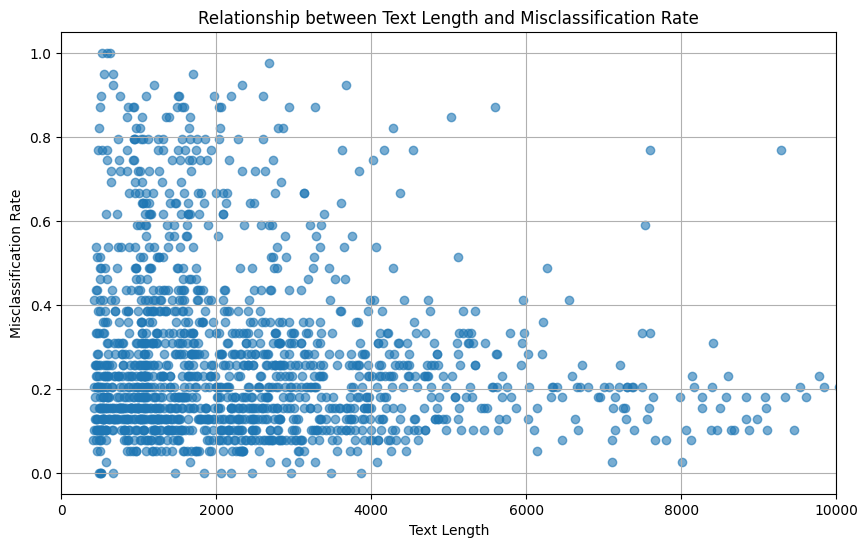

In [31]:
pdf = pd.merge(s, most_difficult_docs, on=['doc_id'])
df = pdf
df['text_length'] = df['text'].apply(len)

# Plotting the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['misclassification_rate'], alpha=0.6)
plt.title('Relationship between Text Length and Misclassification Rate')
plt.xlabel('Text Length')
plt.ylabel('Misclassification Rate')
plt.grid(True)
plt.xlim(0, 10000)
plt.show()

##### Category confusion - Category confusion is not represented properly - old/deprecated

* Hearst labels overlap - therefore graph is misleading and untrue - we should only plot the binary classes.

Overall

In [76]:
#!pip install seaborn
import seaborn as sns
def get_cats_conf(sett):
    df_heats_wrong = get_most_difficult_docs(sett)

    sin = [[]] * 8
    for i, val in df_heats_wrong.reset_index().iterrows():
        idd = val.doc_id
        rate = val.misclassification_rate
        sin[(int(email_genre_map.get(idd))-1)] = sin[(int(email_genre_map.get(idd))-1)] + [rate]

    average_values = [sum(arr) / len(arr) for arr in sin]
    print(average_values)
    #return 1
    plot_agg_data = {'category':list(hearst_genres.values()), 'misclassification_rate':average_values}

    agg_data = pd.DataFrame.from_dict(plot_agg_data)

    colors = ['red' if 'Purely Personal' in cat or 'Personal but in professional context' in cat else 'blue' for cat in agg_data['category']]

    transparency = [(1-(1 - rate)/2) for rate in agg_data['misclassification_rate']]

    plt.figure(figsize=(10, 6))
    sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)
    for i in range(len(transparency)):
        plt.gca().get_children()[i].set_alpha(transparency[i])
    plt.xlabel('Misclassification Rate')
    plt.ylabel('Category')
    plt.title('Misclassification Rate by Category')
    plt.show()

    return average_values


Overlap shown:

In [2]:
for v in cat_2:
    if v in cat_1:
        print('Overlap')

[0.12721893491124261, 0.6923076923076923, 0.8172043010752689, 0.1731958762886598, 0.3516483516483517, 0.17088607594936708, 0.20833333333333334, 0.19047619047619047]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


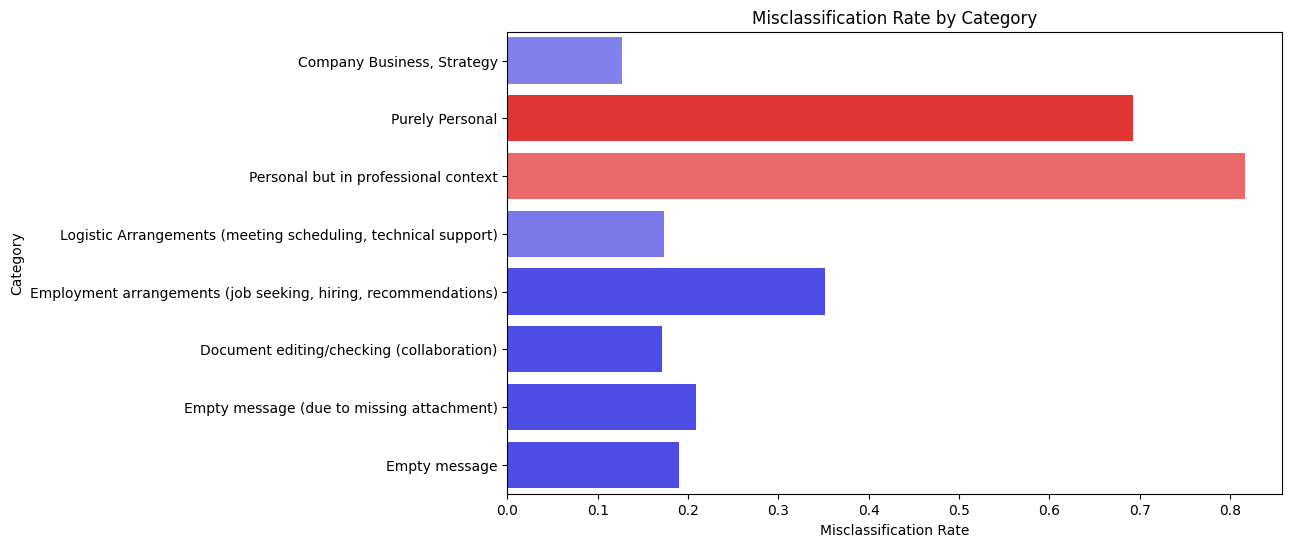

In [77]:
sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='base')]
get_cats_conf(sett)
sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='sens_cats_sens_few')]


[0.07544378698224852, 0.15384615384615385, 0.6451612903225806, 0.20618556701030927, 0.4065934065934066, 0.12658227848101267, 0.08333333333333333, 0.0]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


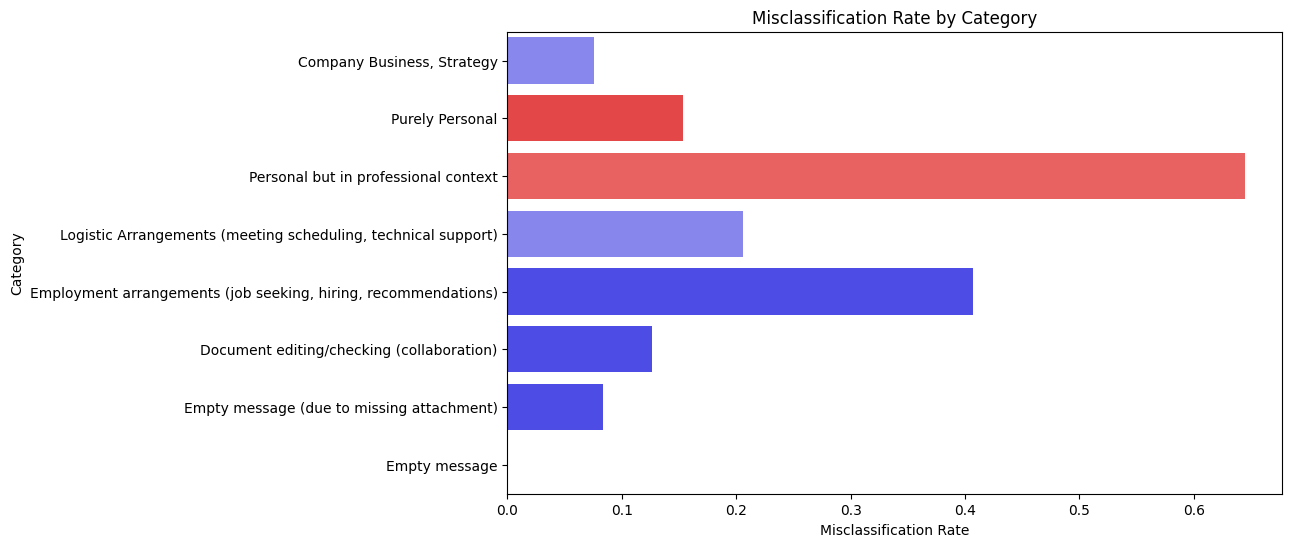

[0.07544378698224852,
 0.15384615384615385,
 0.6451612903225806,
 0.20618556701030927,
 0.4065934065934066,
 0.12658227848101267,
 0.08333333333333333,
 0.0]

In [78]:
get_cats_conf(sett)

[0.11390532544378698, 0.5769230769230769, 0.7956989247311828, 0.2, 0.45054945054945056, 0.20253164556962025, 0.20833333333333334, 0.047619047619047616]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


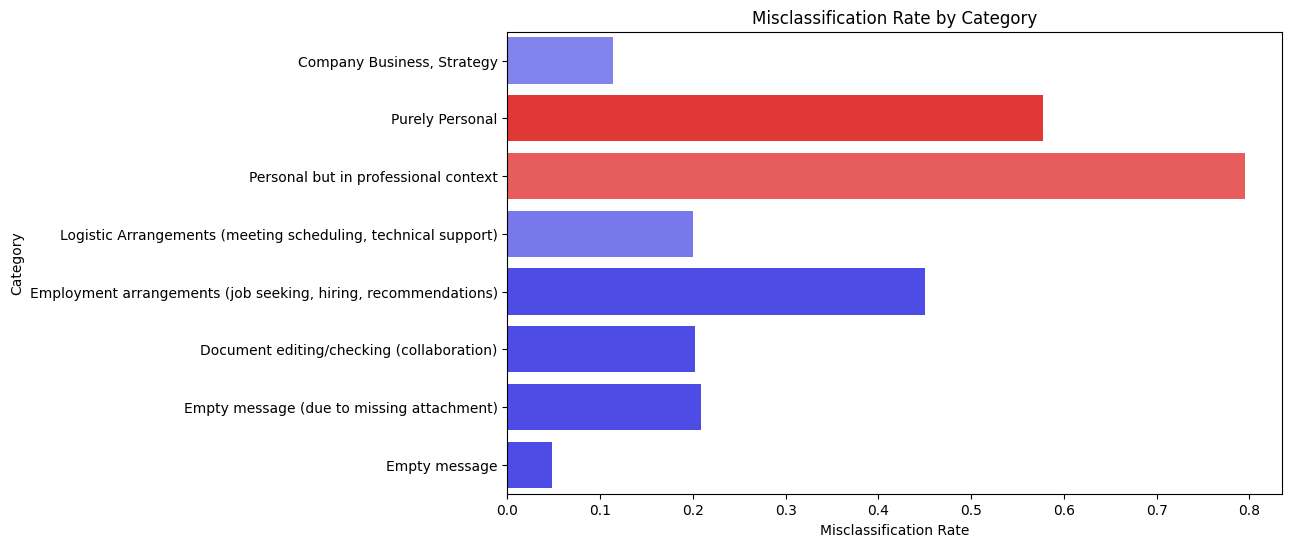

[0.02514792899408284, 0.6923076923076923, 0.7956989247311828, 0.13814432989690723, 0.26373626373626374, 0.06962025316455696, 0.041666666666666664, 0.0]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


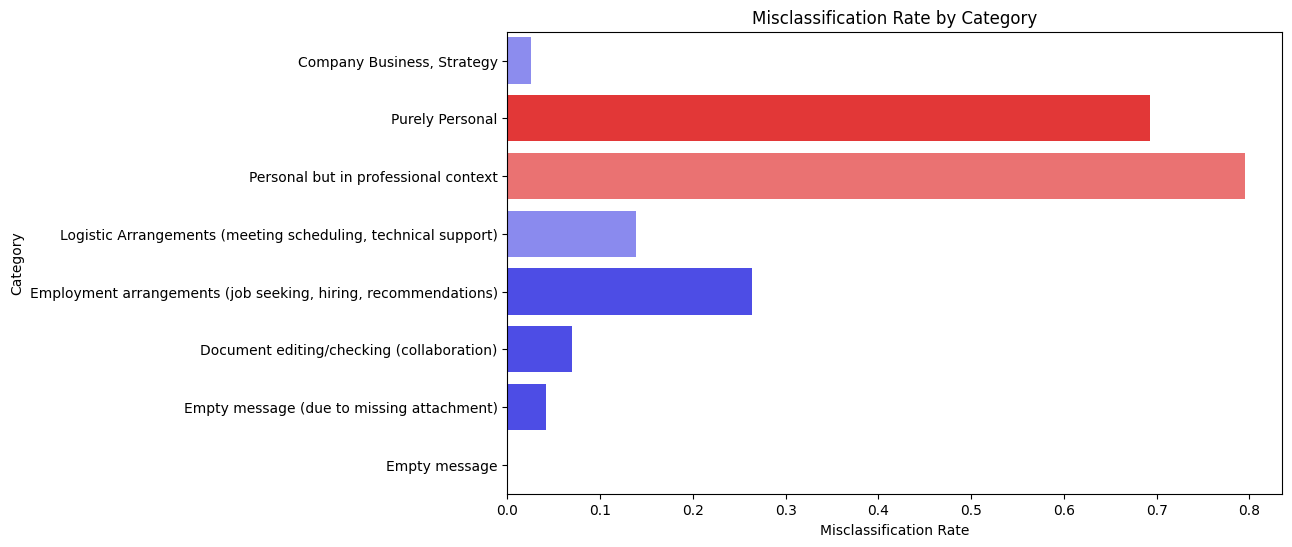

[0.04437869822485207, 0.3076923076923077, 0.7419354838709677, 0.13814432989690723, 0.3516483516483517, 0.10126582278481013, 0.125, 0.047619047619047616]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


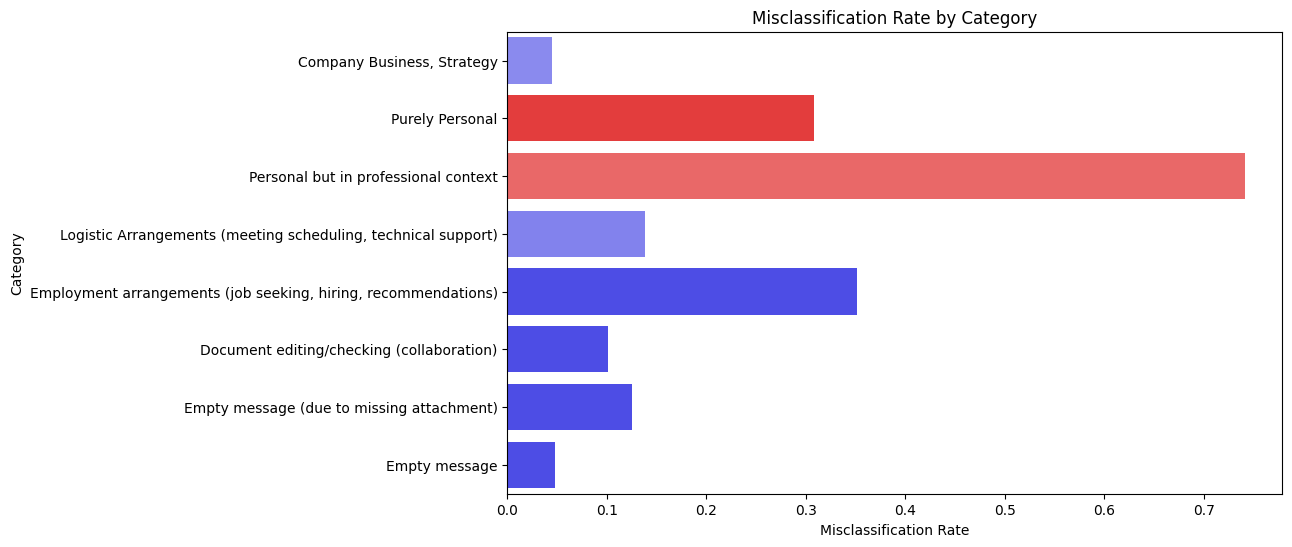

[0.023668639053254437, 0.34615384615384615, 0.7741935483870968, 0.15463917525773196, 0.2857142857142857, 0.08860759493670886, 0.0, 0.0]


/tmp/ipykernel_998/2192331714.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='misclassification_rate', y='category', data=agg_data, palette=colors, alpha=0.8)


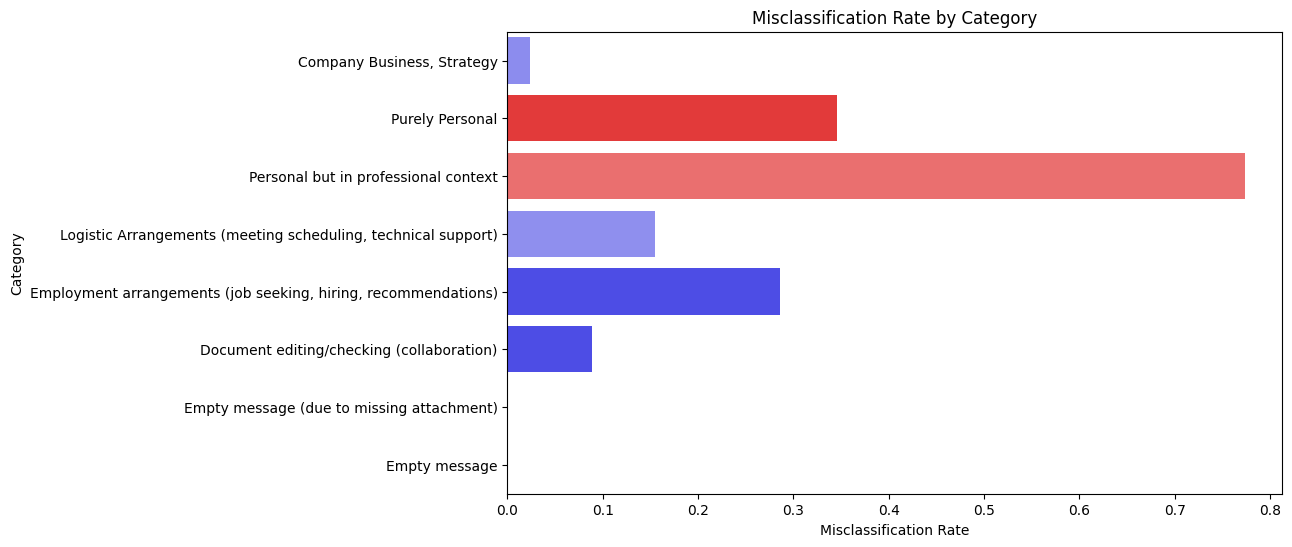

In [68]:
sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='base_sens')]
x = get_cats_conf(sett)
sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='sens_cats')]
y = get_cats_conf(sett)

sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='all_cats')]
y = get_cats_conf(sett)
sett = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='sens_cats_sens')]
y = get_cats_conf(sett)


In [100]:
np.array(y) / np.array(x)

/tmp/ipykernel_23935/4254215513.py:1: RuntimeWarning: divide by zero encountered in divide
  np.array(y) / np.array(x)


array([0.52884615, 0.68421053, 0.88732394, 0.64772727, 0.76666667,
       0.42307692, 0.75      ,        inf])

Frequent words

In [20]:
import spacy

In [21]:
nlp = spacy.load("en_core_web_sm")
stop_words_extra = ['california', 'electricity', 'original', 'forwarded', 'by', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come']
for word in stop_words_extra:
    nlp.vocab[word].is_stop = True

#proc_all_wrong = no_reply_proc(docs_all_wrong, 'mist-noreply')

In [25]:

def get_most_counts(n, df):

    def remove_stop(text):
        doc = nlp(text)
        tokens = [t.text for t in doc if not t.is_stop]
        #bigrams = [tokens[i] + ' ' + tokens[i+1] for i in range(len(tokens)-1)]
        #tokens=bigrams
        #print(tokens)
        return tokens
    
    #proc_all_wrong

    df['tokens'] = df['text'].apply(remove_stop)

    all_ts = [token for sublist in df['tokens'] for token in sublist]
    from collections import Counter

    #token_counts = Counter([token for sublist in x['tokens'] for token in sublist])
    token_counts = Counter(all_ts)
    print(token_counts.most_common(n))

get_most_counts(50, p[p.sensitivity == 0])

NameError: name 'p' is not defined

In [151]:
def evaluate_interesting_docs(search, display=False):
    sum_seen = 0
    cat = [0] * 8
    for i, samp in s.iterrows():
        t = samp.text
        idd = samp.doc_id
        if search in t:
            sum_seen += 1
            cat[(int(email_genre_map.get(idd))-1)] += 1
            if display:
                print(hearst_genres.get(email_genre_map.get(idd)))
                print(t)
                #print()

    print(sum_seen)
    print(cat)
    return cat

#evaluate_interesting_docs('jpg')
#evaluate_interesting_docs(' you ')
#evaluate_interesting_docs('attach')
#evaluate_interesting_docs('president')

In [70]:
evaluate_interesting_docs('www')
evaluate_interesting_docs('http')



210
[121, 2, 20, 42, 12, 9, 1, 3]
247
[132, 3, 17, 66, 12, 11, 1, 5]


[132, 3, 17, 66, 12, 11, 1, 5]

In [47]:
np.array(evaluate_interesting_docs('www')) / np.array(evaluate_interesting_docs(''))


210
[129, 2, 20, 38, 10, 8, 1, 2]
1702
[834, 36, 100, 476, 74, 143, 21, 18]


array([0.15467626, 0.05555556, 0.2       , 0.07983193, 0.13513514,
       0.05594406, 0.04761905, 0.11111111])

In [27]:
def evaluate_interesting_docs_sns(search, display=False):
    sum_seen = 0
    cat = [0] * 2
    for i, samp in s.iterrows():
        ss = samp.sensitivity
        t = samp.text
        if search in t:
            cat[ss] += 1
            sum_seen += 1

    print(cat)
    return cat

In [52]:
evaluate_interesting_docs_sns('www')

[176, 34]


[176, 34]

In [33]:
176/1400

0.12571428571428572

##### TNSE plot - didnt work

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


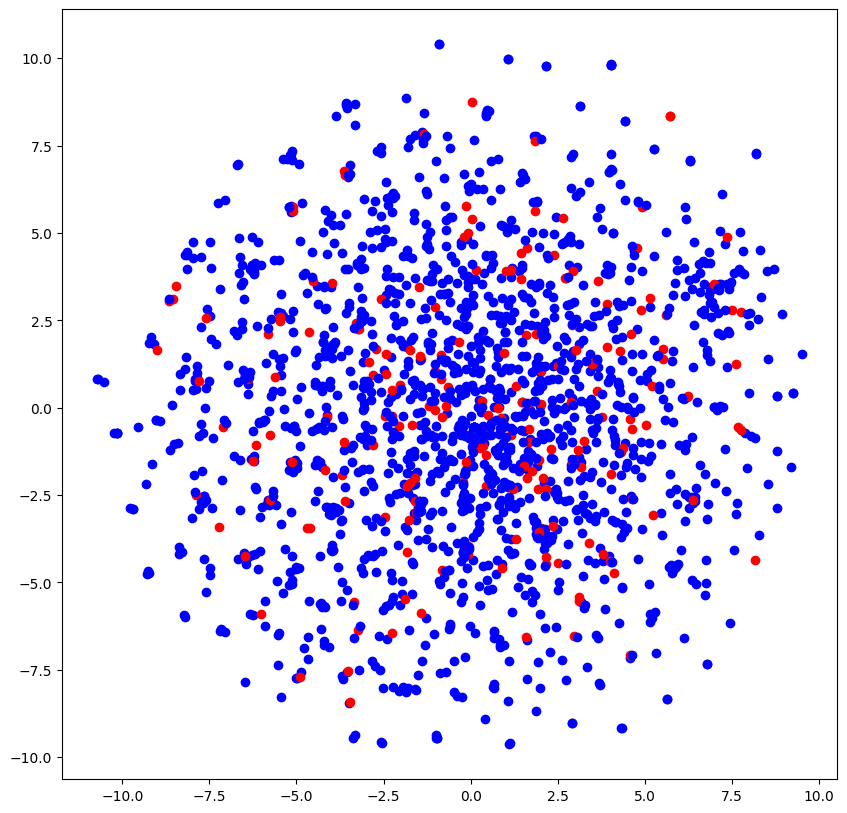

In [28]:
from model_map import *
def tnse_exploration():
    tokenizer = AutoTokenizer.from_pretrained(model_map.get("mist-noreply")[1], use_fast=True)
    s_clean = no_reply_proc(s, 'mist-noreply')
    s_clean = full_preproc(s, 'mist-noreply')
    embeddings = [tokenizer(text, return_tensors='pt').input_ids.flatten().numpy() for text in s_clean.text]
    fix = np.array([np.pad(doc, (0, 2050 - len(doc)), 'constant') for doc in embeddings])

    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=1, perplexity=50)
    embeddings_reduced = tsne.fit_transform(fix.reshape(fix.shape[0], -1))
    plt.figure(figsize=(10,10))

    for i, point in enumerate(embeddings_reduced):
        if s_clean.iloc[i].sensitivity == 0:
            plt.scatter(point[0], point[1], color='blue')
        else:
            plt.scatter(point[0], point[1], color='red')


    plt.show()

tnse_exploration()

##### More Difficult documents

Mistral most difficult

In [23]:
difficult_df = all_results_df[(all_results_df.model=='mist-noreply') & ((all_results_df.prompt=='base') | (all_results_df.prompt=='base_sens') | (all_results_df.prompt=='all_cats') | (all_results_df.prompt=='sens_cats') | (all_results_df.prompt=='all_cats_sens') | (all_results_df.prompt=='sens_cats_sens'))]
#difficult_df = difficult_df[difficult_df['prompt'].isin(prompts)]
most_difficult_docs = get_most_difficult_docs(difficult_df)
hard_docs = get_all_wrong_docs(most_difficult_docs[:100])

In [24]:
difficult_df

,doc_id,prediction,ground_truth,model,prompt
4722,173164,0,0,mist-noreply,base_sens
4723,162684,0,0,mist-noreply,base_sens
4724,174260,0,0,mist-noreply,base_sens
4725,121748,0,1,mist-noreply,base_sens
4726,176657,0,0,mist-noreply,base_sens
...,...,...,...,...,...
20457,125762,0,0,mist-noreply,sens_cats
20458,234238,0,0,mist-noreply,sens_cats
20459,174214,0,0,mist-noreply,sens_cats
20460,175841,0,0,mist-noreply,sens_cats


In [25]:
all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]

In [26]:
hard_docs = get_all_wrong_docs(all_wrong_docs)

In [27]:
p = no_reply_proc(hard_docs)
get_most_counts(50, p[p.sensitivity == 1])

NameError: name 'get_most_counts' is not defined

In [28]:
hard_docs.sensitivity.value_counts()

sensitivity
1    90
0    17
Name: count, dtype: int64

In [79]:
eval_docs_wrong(hard_docs, 1)


Document 176675 Class 1 Cat Logistic Arrangements (meeting scheduling, technical support)
please call me forwarded by steven j kean na enron on pm from jody underwood on pm to steven j cc subject memo
Message-ID: <7493853.1075849875061.JavaMail.evans@thyme>
Date: Wed, 13 Jun 2001 09:52:00 -0700 (PDT)
From: steven.kean@enron.com
To: john.lavorato@enron.com, kevin.hannon@enron.com, jeff.skilling@enron.com
Subject: MEMO
Cc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
X-From: Steven J Kean
X-To: John J Lavorato, Kevin Hannon, Jeff Skilling
X-cc: Kelly Kimberly, Karen Denne, Mark Palmer
X-bcc: 
X-Folder: \Steven_Kean_Nov2001_1\Notes Folders\All documents
X-Origin: KEAN-S
X-FileName: skean.nsf

Please call me.
---------------------- Forwarded by Steven J Kean/NA/Enron on 06/13/2001 
04:49 PM -------

all most difficult

In [152]:
def get_wrong_labels(top=False):
    models = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
    for m in models:
        print(m)
        difficult_df = all_results_df[(all_results_df.model==m)] # & ((all_results_df.prompt=='base') | (all_results_df.prompt=='base_sens') | (all_results_df.prompt=='all_cats') | (all_results_df.prompt=='sens_cats') | (all_results_df.prompt=='all_cats_sens') | (all_results_df.prompt=='sens_cats_sens'))]
        #difficult_df = difficult_df[difficult_df['prompt'].isin(prompts)]
        most_difficult_docs = get_most_difficult_docs(difficult_df)
        if top:
            all_wrong_docs = most_difficult_docs[:50]
        else:    
            all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
        hard_docs = get_all_wrong_docs(all_wrong_docs)
        incorrect_label_summary = hard_docs.sensitivity.value_counts()
        print(incorrect_label_summary)
        print(most_difficult_docs.misclassification_rate[46:50])


    difficult_df = all_results_df
    most_difficult_docs = get_most_difficult_docs(difficult_df)
    if top:
        all_wrong_docs = most_difficult_docs[:50]
    else:    
        all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
    hard_docs = get_all_wrong_docs(all_wrong_docs)
    incorrect_label_summary = hard_docs.sensitivity.value_counts()
    print(incorrect_label_summary)
    print(most_difficult_docs.misclassification_rate[46:50])


In [164]:
get_wrong_labels(top=True)

mist-noreply
sensitivity
1    44
0     6
Name: count, dtype: int64
538     1.0
1378    1.0
1568    1.0
932     1.0
Name: misclassification_rate, dtype: float64
mixt-noreply
sensitivity
1    33
0    17
Name: count, dtype: int64
1399    0.923077
897     0.923077
430     0.923077
1562    0.923077
Name: misclassification_rate, dtype: float64
l27b-noreply
sensitivity
1    37
0    13
Name: count, dtype: int64
575     0.769231
1025    0.769231
1381    0.769231
1452    0.769231
Name: misclassification_rate, dtype: float64
sensitivity
1    43
0     7
Name: count, dtype: int64
741     0.820513
19      0.820513
917     0.820513
1022    0.820513
Name: misclassification_rate, dtype: float64


In [167]:
top = True
difficult_df = all_results_df
most_difficult_docs = get_most_difficult_docs(difficult_df)
if top:
    all_wrong_docs = most_difficult_docs[:50]
else:    
    all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
hard_docs = get_all_wrong_docs(all_wrong_docs)
incorrect_label_summary = hard_docs.sensitivity.value_counts()
print(incorrect_label_summary)

sensitivity
1    43
0     7
Name: count, dtype: int64


In [172]:
top = True
difficult_df = all_results_df[all_results_df.model=='l27b-noreply']
most_difficult_docs = get_most_difficult_docs(difficult_df)
if top:
    all_wrong_docs = most_difficult_docs[:50]
else:    
    all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
hard_docs2 = get_all_wrong_docs(all_wrong_docs)
incorrect_label_summary = hard_docs2.sensitivity.value_counts()
print(incorrect_label_summary)

sensitivity
1    37
0    13
Name: count, dtype: int64


In [173]:
y = hard_docs.doc_id.to_list()
z = hard_docs2.doc_id.to_list()

cc = 0
for a in y:
    if a in z:
        cc+=1

print(cc)


16


In [159]:
hard_docs

,doc_id,text,sensitivity
0,54671,http www pserc wisc edu index_home html,1
1,54566,http www ssrn com,1
2,54662,http www housingfinance org country specific i...,1
3,54674,http www vaionline it,1


In [174]:
hard_docs = no_reply_proc(hard_docs)
print(hard_docs)


    doc_id                                               text  sensitivity
0    54549  original message from nw security and bug patc...            1
1    54554  martin you may find it useful vince original m...            1
2    54615  original message from koepke gwyn sent tuesday...            1
3    54616  original message from koepke gwyn sent tuesday...            1
4    54619  original message from enron on behalf of ena p...            1
5    54643  original message from dupont anita sent wednes...            1
6    54644  original message from andrews naveen sent wedn...            1
7    54647  maureen how do you generate this forecast vinc...            1
8    54668  http www pserc wisc edu ecow get publicatio sp...            1
9    54677  original message from lu zimin sent tuesday ju...            1
10  174307  attached is a copy of my california testimony ...            1
11  199911  you are forwarding these messages to the wrong...            1
12  175968  do not circul

In [175]:
eval_docs_wrong(hard_docs, 0)


Document 175968 Class 0 Cat Company Business, Strategy
do not circulate fyi forwarded by steven j kean na enron on pm am to cc subject re confidential cftc chair hi steve folks love newsome and i think hes very nice and appears to be very free market spears the other republican appointee is not at all free market in my view i would not like this to mentioned anywhere else but i have found that the farm reps on the commission may sound deregulatory but are not and have been really troublesome without a good free market person on board and there are no truly free market persons on board at the commission every single other agricultural rep that i worked with on the commission were trouble even though they claimed to be deregulatory and they were far worse before i got there and after i left i visited with newsome a day before inauguration and i was appalled at what they were planning to do concerning agency structure that would have elevated the regulatory lawyers and diminished the role

In [39]:

x = get_results_json('mist-noreply-verbose', clean=False)

In [52]:
hard_docs

,doc_id,text,sensitivity
0,176675,please call me forwarded by steven j kean na e...,1
1,54546,original message from mailto imceanotes enerfa...,1
2,54549,original message from nw security and bug patc...,1
3,54554,martin you may find it useful vince original m...,1
4,54615,original message from koepke gwyn sent tuesday...,1
5,54616,original message from koepke gwyn sent tuesday...,1
6,54619,original message from enron on behalf of ena p...,1
7,54643,original message from dupont anita sent wednes...,1
8,54644,original message from andrews naveen sent wedn...,1
9,54647,maureen how do you generate this forecast vinc...,1


In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_tfidf_terms(row, top_n=5):
    # Converting the row to a Series for easier nlargest use
    row_series = pd.Series(row, index=feature_names)
    top_terms = row_series.nlargest(top_n).index.tolist()
    return top_terms

df = hard_docs # s # pd.DataFrame(data)

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['text'])

feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
final_df = pd.concat([df, tfidf_df], axis=1)

# Applying the function to each row in the DataFrame
top_terms_per_document = tfidf_df.apply(get_top_tfidf_terms, axis=1, top_n=10)

df['top_terms'] = top_terms_per_document


In [77]:
df

,doc_id,text,sensitivity,top_terms
0,176675,please call me forwarded by steven j kean na e...,1,"[steven, jody, underwood, memo, pm, call, on, ..."
1,54546,original message from mailto imceanotes enerfa...,1,"[the, gas, to, energy, in, and, of, natural, s..."
2,54549,original message from nw security and bug patc...,1,"[patch, the, com, security, virus, http, news,..."
3,54554,martin you may find it useful vince original m...,1,"[att, bitmap, device, embedded, independent, p..."
4,54615,original message from koepke gwyn sent tuesday...,1,"[gwyn, venezuela, forecasts, fx, koepke, june,..."
5,54616,original message from koepke gwyn sent tuesday...,1,"[gwyn, koepke, cindy, fx, paddy, padmesh, simu..."
6,54619,original message from enron on behalf of ena p...,1,"[the, eim, steel, of, and, enron, huntco, tran..."
7,54643,original message from dupont anita sent wednes...,1,"[mail, transmission, table, round, to, anita, ..."
8,54644,original message from andrews naveen sent wedn...,1,"[random, is, the, characteristic, compute, fun..."
9,54647,maureen how do you generate this forecast vinc...,1,"[maureen, mitra, behalf, forecast, cpi, raymon..."


In [41]:
for idd in hard_docs.doc_id:
    #print(idd)
    f = x[x.doc_id == idd]
    for i, v in f.iterrows():
        if v.prompt == 'sens_cats_sens_few' and s[s.doc_id==idd].iloc[0].sensitivity==1:
            print(idd)
            print(hearst_genres.get(email_genre_map.get(idd)))
            print(hard_docs[hard_docs.doc_id==idd].iloc[0].text)
            print(s[s.doc_id==idd].iloc[0].text)
            print(v.generated_response)
            print()

    #print(f)
    #.iloc[0].text
    #print(f)
    #break

176675
Company Business, Strategy
please call me forwarded by steven j kean na enron on pm from jody underwood on pm to steven j cc subject memo
Message-ID: <7493853.1075849875061.JavaMail.evans@thyme>
Date: Wed, 13 Jun 2001 09:52:00 -0700 (PDT)
From: steven.kean@enron.com
To: john.lavorato@enron.com, kevin.hannon@enron.com, jeff.skilling@enron.com
Subject: MEMO
Cc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: kelly.kimberly@enron.com, karen.denne@enron.com, mark.palmer@enron.com
X-From: Steven J Kean
X-To: John J Lavorato, Kevin Hannon, Jeff Skilling
X-cc: Kelly Kimberly, Karen Denne, Mark Palmer
X-bcc: 
X-Folder: \Steven_Kean_Nov2001_1\Notes Folders\All documents
X-Origin: KEAN-S
X-FileName: skean.nsf

Please call me.
---------------------- Forwarded by Steven J Kean/NA/Enron on 06/13/2001 
04:49 PM ---------------------------
From: Jody Underwood on 06/13/2001 

In [136]:
#all_results_df[all_results_df.doc_id=='54664']

In [190]:
all_results_df[all_results_df.doc_id=='174265']
 

,doc_id,prediction,ground_truth,model,prompt
81,174265,0,1,mist-noreply,all_cats_sens_hop1
1655,174265,0,1,mist-noreply,all_cats_sens_few
3229,174265,0,1,mist-noreply,base_sens_few
4803,174265,0,1,mist-noreply,base_sens
6377,174265,0,1,mist-noreply,sens_cats_few
7951,174265,0,1,mist-noreply,sens_cats_sens_few
9525,174265,0,1,mist-noreply,all_cats_sens
11099,174265,0,1,mist-noreply,base
12673,174265,0,1,mist-noreply,sens_cats_sens
14247,174265,0,1,mist-noreply,all_cats_few


In [162]:
most_difficult_docs[most_difficult_docs.doc_id=='54664']


,doc_id,misclassification_rate
1493,54664,0.948718


In [142]:
print(s[s.doc_id=='54674'].iloc[0].text)

Message-ID: <12899645.1075863429796.JavaMail.evans@thyme>
Date: Mon, 2 Jul 2001 15:39:50 -0700 (PDT)
From: j.kaminski@enron.com
To: vkaminski@aol.com
Subject: http://www.vaionline.it/
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENTS/CN=VKAMINS>
X-To: 'vkaminski@aol.com'
X-cc: 
X-bcc: 
X-Folder: \VKAMINS (Non-Privileged)\Kaminski, Vince J\Sent Items
X-Origin: Kaminski-V
X-FileName: VKAMINS (Non-Privileged).pst

http://www.vaionline.it/


In [88]:
all_results_df[(all_results_df.doc_id=='229816') & (all_results_df.prediction==0)]

,doc_id,prediction,ground_truth,model,prompt
5426,229816,0,0,mist-noreply,base_sens
11722,229816,0,0,mist-noreply,base
49494,229816,0,0,l27b-noreply,sens_cats_sens_few
58938,229816,0,0,l27b-noreply,base_few


In [90]:
email_genre_map.get('229816')

'5'

In [43]:
l = hard_docs.doc_id.to_list()

In [57]:
v = x[x.prompt=='sens_cats_sens_few']


new = v[v["doc_id"].isin(l)]
new = new.reset_index()

In [58]:
df_final = pd.merge(new, s, on=['doc_id']).reset_index()
df_final

,level_0,index,model,prompt,doc_id,generated_response,text,sensitivity
0,0,3,mist-noreply-verbose,sens_cats_sens_few,121748,"\n\nAnswer: [[""personal""], [""non-personal""]. ...",Message-ID: <26937321.1075843427227.JavaMail.e...,1
1,1,10,mist-noreply-verbose,sens_cats_sens_few,119214,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <23542107.1075843330554.JavaMail.e...,1
2,2,26,mist-noreply-verbose,sens_cats_sens_few,54566,"\n\nAnswer: [[""non-personal""]]\n\nThe message...",Message-ID: <24032384.1075863426836.JavaMail.e...,1
3,3,35,mist-noreply-verbose,sens_cats_sens_few,54674,"\n\nAnswer: [[""non-personal""]]\n\nThe message...",Message-ID: <12899645.1075863429796.JavaMail.e...,1
4,4,62,mist-noreply-verbose,sens_cats_sens_few,54671,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <5644939.1075863429705.JavaMail.ev...,1
5,5,81,mist-noreply-verbose,sens_cats_sens_few,174265,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <27255225.1075846172819.JavaMail.e...,1
6,6,94,mist-noreply-verbose,sens_cats_sens_few,54664,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <15202668.1075863429511.JavaMail.e...,1
7,7,102,mist-noreply-verbose,sens_cats_sens_few,54668,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <30128927.1075863429600.JavaMail.e...,1
8,8,117,mist-noreply-verbose,sens_cats_sens_few,54662,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <1054751.1075863429466.JavaMail.ev...,1
9,9,141,mist-noreply-verbose,sens_cats_sens_few,176675,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...",Message-ID: <7493853.1075849875061.JavaMail.ev...,1


In [53]:
new

,index,model,prompt,doc_id,generated_response,tokens
0,3,mist-noreply-verbose,sens_cats_sens_few,121748,"\n\nAnswer: [[""personal""], [""non-personal""]. ...","[ \n\n, Answer, :, [, [, "", personal, "", ], ,,..."
1,10,mist-noreply-verbose,sens_cats_sens_few,119214,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
2,26,mist-noreply-verbose,sens_cats_sens_few,54566,"\n\nAnswer: [[""non-personal""]]\n\nThe message...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
3,35,mist-noreply-verbose,sens_cats_sens_few,54674,"\n\nAnswer: [[""non-personal""]]\n\nThe message...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
4,62,mist-noreply-verbose,sens_cats_sens_few,54671,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
5,81,mist-noreply-verbose,sens_cats_sens_few,174265,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
6,94,mist-noreply-verbose,sens_cats_sens_few,54664,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
7,102,mist-noreply-verbose,sens_cats_sens_few,54668,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
8,117,mist-noreply-verbose,sens_cats_sens_few,54662,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."
9,141,mist-noreply-verbose,sens_cats_sens_few,176675,"\n\nAnswer: [[""non-personal""]]\n\nThis messag...","[ \n\n, Answer, :, [, [, "", non, -, personal, ..."


In [49]:
import spacy

In [62]:

def get_most_counts(n, df):

    def remove_stop(text):
        doc = nlp(text)
        tokens = [t.text for t in doc if not t.is_stop]
        #bigrams = [tokens[i] + ' ' + tokens[i+1] for i in range(len(tokens)-1)]
        #tokens=bigrams
        #print(tokens)
        return tokens
    
    #proc_all_wrong

    df['tokens'] = df['generated_response'].apply(remove_stop)

    all_ts = [token for sublist in df['tokens'] for token in sublist]
    from collections import Counter

    #token_counts = Counter([token for sublist in x['tokens'] for token in sublist])
    token_counts = Counter(all_ts)
    print(token_counts.most_common(n))

get_most_counts(50, df_final[df_final.sensitivity == 1])

[('personal', 107), ('"', 100), ('.', 87), ('[', 72), (']', 71), (',', 67), ('-', 61), (':', 59), ('non', 59), ('message', 49), ('\n\n', 48), (' \n\n', 40), ('Answer', 40), ('related', 38), ('information', 37), ('contain', 34), ('email', 29), ('appears', 28), ('work', 26), ('Explanation', 19), ('sensitive', 16), ('expressions', 13), ('feelings', 13), ('discussing', 13), ('employee', 12), ('treatment', 12), ('specifically', 10), ('classified', 9), ('business', 9), ('comments', 8), ('conference', 6), ('quality', 6), ('individuals', 6), ('Enron', 5), ('elements', 5), ('project', 5), ('employees', 4), ('URL', 4), ('company', 4), ('emails', 4), ('energy', 4), ('contains', 4), ('California', 4), ('crisis', 4), ('people', 4), ('response', 3), ('category', 3), ('falls', 3), ('link', 3), ('file', 3)]


/tmp/ipykernel_17844/1621634696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['generated_response'].apply(remove_stop)


In [22]:
# Analysis of all wrong docs
all_wrong = ['54671', '54566', '54662']
for y in all_wrong:
    for i, m in enumerate(main):
        if y in m:
            print(i+1)

3
3
3


In [82]:
intt = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='all_cats_sens_few')]
intt

,doc_id,prediction,ground_truth,model,prompt
1574,173164,1,0,mist-noreply,all_cats_sens_few
1575,162684,1,0,mist-noreply,all_cats_sens_few
1576,174260,1,0,mist-noreply,all_cats_sens_few
1577,121748,1,1,mist-noreply,all_cats_sens_few
1578,176657,1,0,mist-noreply,all_cats_sens_few
...,...,...,...,...,...
3143,125762,0,0,mist-noreply,all_cats_sens_few
3144,234238,0,0,mist-noreply,all_cats_sens_few
3145,174214,0,0,mist-noreply,all_cats_sens_few
3146,175841,0,0,mist-noreply,all_cats_sens_few


In [89]:
def evaluate_interesting_docs_two_class(search, df, display=False):
    sum_seen = 0
    cat = [0] * 2
    correct = [0] * 2
    #p = no_reply_proc(s, 'mist-noreply')
    for i, samp in df.iterrows():
        t = samp.text
        idd = samp.doc_id
        sens = samp.sensitivity
        if search in t:
            sum_seen += 1
            cat[sens] += 1
            find = intt[(intt.doc_id==idd)].iloc[0]
            if find.prediction == find.ground_truth:
                correct[find.ground_truth] += 1
            if display:
                print(sens)
                print(t)
                #print()

    print(sum_seen)
    print(cat)
    all_sens = np.array(df.sensitivity.to_list())
    total = len(all_sens)
    pos = np.sum(all_sens)
    ratio = np.array(cat) / np.array([total, pos])
    print(ratio)
    print(correct)

    print(np.array(correct) / np.array(cat))
    #return cat

#evaluate_interesting_docs('jpg')
#evaluate_interesting_docs(' you ')
#evaluate_interesting_docs('attach')
evaluate_interesting_docs_two_class('jpg', clean_unique_docs)

6
[2, 4]
[0.00127065 0.02040816]
[2, 2]
[1.  0.5]


In [187]:
intt = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='sens_cats_sens_few')]

In [189]:
def evaluate_interesting_docs_two_class(search, df, display=False):
    sum_seen = 0
    cat = [0] * 2
    correct = [0] * 2
    for i, samp in df.iterrows():
        t = samp.text
        idd = samp.doc_id
        sens = samp.sensitivity
        if search in t:
            sum_seen += 1
            cat[sens] += 1
            find = intt[(intt.doc_id==idd)]
            correct[find.iloc[0].ground_truth] += len(find[find.prediction==find.ground_truth]) / len(find)

    print(sum_seen)
    print(cat)
    all_sens = np.array(df.sensitivity.to_list())
    total = len(all_sens)
    pos = np.sum(all_sens)
    ratio = np.array(cat) / np.array([total, pos])
    print(ratio)
    print(correct)

    print(np.array(correct) / np.array(cat))
    #return cat

#evaluate_interesting_docs('jpg')
#evaluate_interesting_docs(' you ')
#evaluate_interesting_docs('attach')
evaluate_interesting_docs_two_class('test', clean_unique_docs)

190
[184, 6]
[0.11689962 0.03061224]
[181.0, 0.0]
[0.98369565 0.        ]


All correct

In [24]:
def get_least_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=True)


def get_wrong_labels(top=False):
    models = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
    for m in models:
        print(m)
        difficult_df = all_results_df[(all_results_df.model==m)] # & ((all_results_df.prompt=='base') | (all_results_df.prompt=='base_sens') | (all_results_df.prompt=='all_cats') | (all_results_df.prompt=='sens_cats') | (all_results_df.prompt=='all_cats_sens') | (all_results_df.prompt=='sens_cats_sens'))]
        #difficult_df = difficult_df[difficult_df['prompt'].isin(prompts)]
        most_difficult_docs = get_least_difficult_docs(difficult_df)
        if top:
            all_wrong_docs = most_difficult_docs[:50]
        else:    
            all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
        hard_docs = get_all_wrong_docs(all_wrong_docs)
        incorrect_label_summary = hard_docs.sensitivity.value_counts()
        print(incorrect_label_summary)
        print(most_difficult_docs.misclassification_rate[46:50])


    difficult_df = all_results_df
    most_difficult_docs = get_most_difficult_docs(difficult_df)
    if top:
        all_wrong_docs = most_difficult_docs[:50]
    else:    
        all_wrong_docs = most_difficult_docs[most_difficult_docs.misclassification_rate==1.0]
    hard_docs = get_all_wrong_docs(all_wrong_docs)
    incorrect_label_summary = hard_docs.sensitivity.value_counts()
    print(incorrect_label_summary)
    print(most_difficult_docs.misclassification_rate[46:50])

In [25]:
get_wrong_labels(top=True)

mist-noreply
sensitivity
0    49
1     1
Name: count, dtype: int64
1053    0.0
1052    0.0
1051    0.0
580     0.0
Name: misclassification_rate, dtype: float64
mixt-noreply
sensitivity
0    50
Name: count, dtype: int64
696     0.0
1319    0.0
700     0.0
701     0.0
Name: misclassification_rate, dtype: float64
l27b-noreply
sensitivity
0    49
1     1
Name: count, dtype: int64
925    0.076923
123    0.076923
898    0.076923
125    0.076923
Name: misclassification_rate, dtype: float64
sensitivity
1    43
0     7
Name: count, dtype: int64
741     0.820513
19      0.820513
917     0.820513
1022    0.820513
Name: misclassification_rate, dtype: float64


In [35]:
top = True
easy = all_results_df
easy = get_most_difficult_docs(easy)
if top:
    all_wrong_docs = easy[:50]
else:    
    all_wrong_docs = easy[easy.misclassification_rate==0.0]
easy_docs = get_all_wrong_docs(all_wrong_docs)
correct_label_summary = easy_docs.sensitivity.value_counts()
print(correct_label_summary)

sensitivity
1    43
0     7
Name: count, dtype: int64


In [36]:
eval_docs_wrong(easy_docs, 1)

Document 54549 Class 1 Cat Personal but in professional context
Message-ID: <1481316.1075863426405.JavaMail.evans@thyme>
Date: Fri, 15 Jun 2001 09:10:26 -0700 (PDT)
From: j.kaminski@enron.com
To: vincek@leland.stanford.edu
Subject: FW: McVeigh video really a virus
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENTS/CN=VKAMINS>
X-To: 'vincek@leland.Stanford.edu'
X-cc: 
X-bcc: 
X-Folder: \VKAMINS (Non-Privileged)\Kaminski, Vince J\Sent Items
X-Origin: Kaminski-V
X-FileName: VKAMINS (Non-Privileged).pst



 -----Original Message-----
From: 	NW Security and Bug Patch Alert <Security-BugPatch@bdcimail.com>@ENRON [mailto:IMCEANOTES-NW+20Security+20and+20Bug+20Patch+20Alert+20+3CSecurity-BugPatch+40bdcimail+2Ecom+3E+40ENRON@ENRON.com] 
Sent:	Thursday, June 14, 2001 4:52 PM
To:	vkamins@enron.com
Subject:	McVeigh video really a virus

NETWORK WORLD NEWSLETTER: JASON MESERVE
on SECURITY AND BUG PATCH

### Statistical Testing - McNemar

In [1]:
def evaluation_summary(true_labels, predictions):
    target_labels = [0, 1]
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    report = classification_report(true_labels, predictions, labels=target_labels, target_names=target_classes, digits=3, zero_division=0)
    #print(report)
    confusionMatrix = confusion_matrix(true_labels, predictions, labels=target_labels)
    fig = plt.figure(1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes)
    disp.plot()
    #disp.figure_.savefig(description+"confusion_matrix.pdf")
    plt.show()
    return disp

#evaluation_summary([1,0,0], [1,0,1])

In [2]:
all_results_df

NameError: name 'all_results_df' is not defined

In [3]:
def get_colour_conf_mat(m, p, df=all_results_df):
    df = df[df.model==m]
    df = df[df.prompt==p]
    p = df.prediction.to_list()
    t = df.ground_truth.to_list()
    evaluation_summary(t, p)


get_colour_conf_mat('mist-noreply', 'all_cats_sens_few')

NameError: name 'all_results_df' is not defined

In [4]:
for p in prompt_order:
    get_colour_conf_mat('l27b-noreply', p)


NameError: name 'prompt_order' is not defined

In [5]:
prompt_order

NameError: name 'prompt_order' is not defined

#### Old mcnemar

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()
    contingency_table = [[0, 0], [0, 0]]
    for i, val in enumerate(ground_list):
        if (val == 1) and (model1_predictions[i] == val) and (model2_predictions[i] == val):
            contingency_table[0][0] += 1
        elif (val == 1) and (model1_predictions[i] == val):
            contingency_table[0][1] += 1
        elif (val == 1) and (model2_predictions[i] == val):
            contingency_table[1][0] += 1
        else:
            contingency_table[1][1] += 1
    
    #print(contingency_table)
    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if (model_name != model_name2) and (prompt_name != prompt_name2):
        print('Multiple difference')
        return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
    else:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)

    print('Overall')
    print(np.matrix(overall_table[0]))
    print(np.matrix(overall_table[1]))
    return overall_table



model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('details', 'detailsfew')] #, ('details', 'det1'), ('det1', 'det2')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    #run_mcnemar(overall)

Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: details 	Change: detailsfew


NameError: name 'focused_df' is not defined

In [ ]:
focused_df = all_results_df[(all_results_df.prompt == 'cg') | (all_results_df.prompt == 'cgfew') | (all_results_df.prompt == 'hop1')]

In [ ]:
focused_df.prompt.unique()

array(['cgfew', 'cg', 'hop1'], dtype=object)

In [ ]:
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), 
           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]
compare = [('cg', 'cgfew'), ('cg', 'hop1'), ('cgfew', 'hop1')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    run_mcnemar(overall)

Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: cg 	Change: cgfew
Overall		 Non-sensitive only	 Sensitive only
[[843 172]] 	 [[713 160]] 		 [[130  12]]
[[130 429]] 	 [[117 388]] 		 [[13 41]]
statistic=130.000, p-value=1.8163E-02
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: cg 	Change: hop1
Overall		 Non-sensitive only	 Sensitive only
[[761 254]] 	 [[672 201]] 		 [[89 53]]
[[331 228]] 	 [[318 187]] 		 [[13 41]]
statistic=254.000, p-value=1.6540E-03
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 

#### New mcnemar

In [23]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    return result.statistic, result.pvalue
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

    '''
    BOTH_COR                                   CONTROL_COR (Classification 1 correct)
    CHANGE_COR (Classification 2 correct)      BOTH_WRONG
    '''

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_both(results_df, p1, p2, m1, m2):
    orig = results_df[(results_df.model == m1) & (results_df.prompt==p1)]
    pure = results_df[(results_df.model == m2) & (results_df.prompt==p2)]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
    elif model_name != model_name2:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
    else:
        results_df = df[(df.model == model_name) | (df.model == model_name2)]
        overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)

    stat, p = run_mcnemar(overall_table)
    return {'prompt1':prompt_name, 'prompt2':prompt_name2, 'model': model_name, 'model2': model_name2, 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.01)}

def full_mcnemar_prompts_helper(model_name):

    #model_name = 'mist-noreply'
    model_name2 = model_name
    
    base_sign = [('base', 'sens_cats'), ('base', 'all_cats'), ('base', 'base_sens'), ('base', 'sens_cats_sens'), ('base', 'all_cats_sens')]
    base_sign_fs = [('base', 'base_few'), ('base', 'sens_cats_few'), ('base', 'all_cats_few'), ('base', 'base_sens_few'), ('base', 'sens_cats_sens_few'), ('base', 'all_cats_sens_few')]
    fs_sign = [('base', 'base_few'), ('sens_cats', 'sens_cats_few'), ('all_cats', 'all_cats_few'), ('base_sens', 'base_sens_few'), ('sens_cats_sens', 'sens_cats_sens_few'), ('all_cats_sens', 'all_cats_sens_few')]
    base_sign_cot = [('base', 'all_cats_sens_hop1')]
    cot_sign = [('all_cats_sens', 'all_cats_sens_hop1')]
    compare = base_sign + base_sign_fs + fs_sign + base_sign_cot + cot_sign
    
    stat_tests = []
    for v in compare:
        prompt_name = v[0]
        prompt_name2 = v[1]
        instance_stats = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
        stat_tests.append(instance_stats)
    #stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests


def full_mcnemar_models_helper(prompt_name):
    #prompt_name = 'base'
    prompt_name2 = prompt_name
    
    models_sign = [('mist-noreply', 'mixt-noreply'), ('mist-noreply', 'l27b-noreply'), ('l27b-noreply', 'mixt-noreply')]
    compare = models_sign
    
    stat_tests = []
    for v in compare:
        model_name = v[0]
        model_name2 = v[1]
        instance_stats = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
        stat_tests.append(instance_stats)
    #stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests

def full_mcnemar_models():
    stat_tests = []
    prompts = ['base', 'sens_cats', 'all_cats', 'base_sens', 'sens_cats_sens', 'all_cats_sens', 'base_few', 'sens_cats_few', 'all_cats_few', 'base_sens_few', 'sens_cats_sens_few', 'all_cats_sens_few', 'all_cats_sens_hop1']
    for p in prompts:
        stat_tests += full_mcnemar_models_helper(p)

    stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests

def full_mcnemar_prompts():
    stat_tests = []
    models = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
    for p in models:
        stat_tests += full_mcnemar_prompts_helper(p)

    stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests


full_mcnemar_prompts()

,prompt1,prompt2,model,model2,statistic,p-value,significant
0,base,sens_cats,mist-noreply,mist-noreply,41.0,2.13E-17,True
1,base,all_cats,mist-noreply,mist-noreply,55.0,2.97E-13,True
2,base,base_sens,mist-noreply,mist-noreply,53.0,1.49E-01,False
3,base,sens_cats_sens,mist-noreply,mist-noreply,64.0,4.20E-13,True
4,base,all_cats_sens,mist-noreply,mist-noreply,72.0,4.51E-11,True
5,base,base_few,mist-noreply,mist-noreply,55.0,9.81E-10,True
6,base,sens_cats_few,mist-noreply,mist-noreply,118.0,9.27E-05,True
7,base,all_cats_few,mist-noreply,mist-noreply,77.0,2.00E-11,True
8,base,base_sens_few,mist-noreply,mist-noreply,88.0,7.04E-05,True
9,base,sens_cats_sens_few,mist-noreply,mist-noreply,145.0,1.21E-02,False


In [24]:
vv = full_mcnemar_models()


In [48]:
vv

,prompt1,prompt2,model,model2,statistic,p-value,significant
0,base,base,mist-noreply,mixt-noreply,100.0,3.68E-79,True
1,base,base,mist-noreply,l27b-noreply,153.0,1.28E-138,True
2,base,base,l27b-noreply,mixt-noreply,230.0,1.15E-31,True
3,sens_cats,sens_cats,mist-noreply,mixt-noreply,103.0,1.05E-88,True
4,sens_cats,sens_cats,mist-noreply,l27b-noreply,91.0,2.11E-71,True
5,sens_cats,sens_cats,l27b-noreply,mixt-noreply,354.0,1.61E-03,True
6,all_cats,all_cats,mist-noreply,mixt-noreply,96.0,3.54E-79,True
7,all_cats,all_cats,mist-noreply,l27b-noreply,82.0,8.79E-38,True
8,all_cats,all_cats,l27b-noreply,mixt-noreply,262.0,4.68E-14,True
9,base_sens,base_sens,mist-noreply,mixt-noreply,116.0,2.40E-58,True


In [49]:
vv[(vv.model=='mist-noreply') & (vv.model2=='mixt-noreply')]

,prompt1,prompt2,model,model2,statistic,p-value,significant
0,base,base,mist-noreply,mixt-noreply,100.0,3.68E-79,True
3,sens_cats,sens_cats,mist-noreply,mixt-noreply,103.0,1.05E-88,True
6,all_cats,all_cats,mist-noreply,mixt-noreply,96.0,3.54E-79,True
9,base_sens,base_sens,mist-noreply,mixt-noreply,116.0,2.40E-58,True
12,sens_cats_sens,sens_cats_sens,mist-noreply,mixt-noreply,77.0,2.63E-50,True
15,all_cats_sens,all_cats_sens,mist-noreply,mixt-noreply,78.0,2.52E-56,True
18,base_few,base_few,mist-noreply,mixt-noreply,59.0,2.32E-03,True
21,sens_cats_few,sens_cats_few,mist-noreply,mixt-noreply,55.0,8.25E-04,True
24,all_cats_few,all_cats_few,mist-noreply,mixt-noreply,55.0,3.19E-01,False
27,base_sens_few,base_sens_few,mist-noreply,mixt-noreply,65.0,5.18E-03,True


In [50]:
def mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, df):
    results_df = df[(df.model == model_name) | (df.model == model_name2)]
    overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)
    non_results_df = df[df['ground_truth'] == 0]
    non_table = mc_eval_util_both(non_results_df, prompt_name, prompt_name2, model_name, model_name2)
    sen_results_df = df[df['ground_truth'] == 1]
    sen_table = mc_eval_util_both(sen_results_df, prompt_name, prompt_name2, model_name, model_name2)

    print('Overall\t\t Non-sensitive only\t Sensitive only')
    print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))

    stat, p = run_mcnemar(overall_table)
    print(('%.4E' % p))
    return {'prompt1':prompt_name, 'prompt2':prompt_name2, 'model': model_name, 'model2': model_name2, 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.01)}

def mcn_out(model_name):

    model_name = 'mist-noreply'
    model_name2 = 'mixt-noreply'
    
    compare =  [('sens_cats_sens_few', 'all_cats_sens')]
    
    stat_tests = []
    for v in compare:
        prompt_name = v[0]
        prompt_name2 = v[1]
        instance_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
        stat_tests.append(instance_stats)
    #stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests


instance_stats = mcn_out('c')



Overall		 Non-sensitive only	 Sensitive only
[[924 378]] 	 [[838 369]] 		 [[86  9]]
[[ 98 174]] 	 [[ 52 119]] 		 [[46 55]]
8.0138E-40


##### McNemar Heatmap

In [51]:
def mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, df):
    results_df = df[(df.model == model_name) | (df.model == model_name2)]
    overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)
    non_results_df = df[df['ground_truth'] == 0]
    non_table = mc_eval_util_both(non_results_df, prompt_name, prompt_name2, model_name, model_name2)
    sen_results_df = df[df['ground_truth'] == 1]
    sen_table = mc_eval_util_both(sen_results_df, prompt_name, prompt_name2, model_name, model_name2)

    #print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    #print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))

    return overall_table

def mcn_out(model_name):

    model_name = 'mist-noreply'
    model_name2 = 'mist-noreply'
    
    compare =  [('base', 'all_cats')]
    
    stat_tests = []
    for v in compare:
        prompt_name = v[0]
        prompt_name2 = v[1]
        instance_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
        stat_tests.append(instance_stats)
    #stat_tests = pd.DataFrame.from_dict(stat_tests)
    return stat_tests


x = instance_stats = mcn_out('c')

In [52]:
x

[[[1200, 55], [161, 158]]]

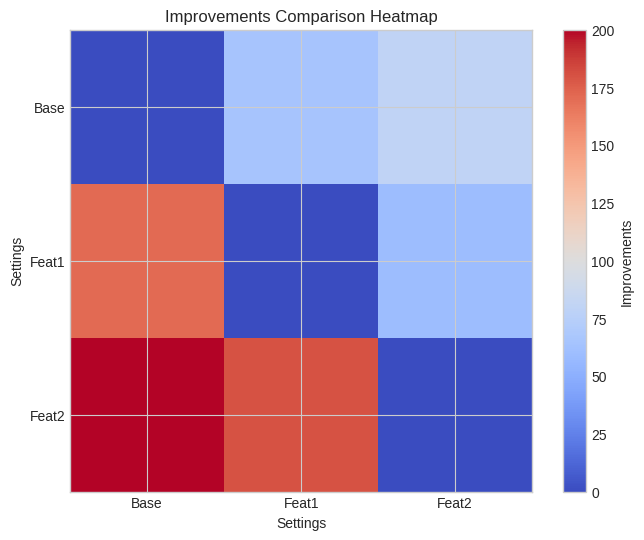

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def jj(x):
    for comp in x:
        improve_control = x[0, 1]
        improve_change = x[1, 0]
        break




# Example tables
table_base_feat1 = np.array([[1177, 65], [171, 161]])  # Base vs. Feat1
table_base_feat2 = np.array([[1200, 80], [200, 150]])  # Base vs. Feat2
table_feat1_feat2 = np.array([[1220, 60], [180, 140]])  # Feat1 vs. Feat2

x = [table_base_feat1, table_base_feat2, table_feat1_feat2]

# Calculate improvements
improvements_base_feat1 = table_base_feat1[0, 1]
improvements_feat1_base = table_base_feat1[1, 0]

improvements_base_feat2 = table_base_feat2[0, 1]
improvements_feat2_base = table_base_feat2[1, 0]

improvements_feat1_feat2 = table_feat1_feat2[0, 1]
improvements_feat2_feat1 = table_feat1_feat2[1, 0]

# Create heatmap data
heatmap_data = np.array([[0, improvements_base_feat1, improvements_base_feat2],
                         [improvements_feat1_base, 0, improvements_feat1_feat2],
                         [improvements_feat2_base, improvements_feat2_feat1, 0]])

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='coolwarm', interpolation='nearest')
plt.title('Improvements Comparison Heatmap')
plt.xlabel('Settings')
plt.ylabel('Settings')
plt.xticks(np.arange(3), ['Base', 'Feat1', 'Feat2'])
plt.yticks(np.arange(3), ['Base', 'Feat1', 'Feat2'])
plt.colorbar(label='Improvements')
plt.show()


In [54]:
g = np.zeros((3,3))
print(g)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [55]:
def jj(x, p1, p2):
    improve_control = x[0, 1]
    improve_change = x[1, 0]
    g[mapp.get(p1), mapp.get(p2)] = improve_control
    g[mapp.get(p2), mapp.get(p1)] = improve_change
    #break

model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare =  [('base', 'sens_cats'), ('base', 'all_cats'), ('sens_cats', 'all_cats')]

base_sign = [('base', 'sens_cats'), ('base', 'all_cats'), ('base', 'base_sens'), ('base', 'sens_cats_sens'), ('base', 'all_cats_sens')]
base_sign2 = [('sens_cats', 'all_cats'), ('sens_cats', 'sens_cats_sens'), ('all_cats', 'all_cats_sens'), ('sens_cats_sens', 'all_cats_sens')]

base_sign_fs = [('base', 'base_few'), ('base', 'sens_cats_few'), ('base', 'all_cats_few'), ('base', 'base_sens_few'), ('base', 'sens_cats_sens_few'), ('base', 'all_cats_sens_few')]
fs_sign = [('base', 'base_few'), ('sens_cats', 'sens_cats_few'), ('all_cats', 'all_cats_few'), ('base_sens', 'base_sens_few'), ('sens_cats_sens', 'sens_cats_sens_few'), ('all_cats_sens', 'all_cats_sens_few')]
base_sign_cot = [('base', 'all_cats_sens_hop1')]
cot_sign = [('all_cats_sens', 'all_cats_sens_hop1')]
compare = base_sign +base_sign2 #+ base_sign_fs + fs_sign + base_sign_cot + cot_sign

mapp = {'base':0, 'sens_cats':1, 'all_cats':2, 'base_sens':3, 'sens_cats_sens':4, 'all_cats_sens':5, 
        'base_few':6, 'sens_cats_few':7, 'all_cats_few':8, 'base_sens_few':9, 'sens_cats_sens_few':10, 'all_cats_sens_few':11,
        
        
        }
g = np.zeros((6,6))

stat_tests = []
for v in compare:
    prompt_name = v[0]
    prompt_name2 = v[1]
    instance_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
    #print(instance_stats)
    jj(np.array(instance_stats), prompt_name, prompt_name2)


print(g)

[[  0.  41.  55.  70.  64.  72.]
 [158.   0.  37.   0.  39.   0.]
 [161.  26.   0.   0.   0.  34.]
 [ 53.   0.   0.   0.   0.   0.]
 [175.  33.   0.   0.   0.  43.]
 [175.   0.  31.   0.  35.   0.]]


In [56]:
compare = list(mapp.keys())[:6]

In [57]:
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

In [58]:
g = np.zeros((6,6))

compare = list(mapp.keys())[:6]
for i, v in enumerate(compare):
    for v1 in compare[(i+1):]:
        prompt_name = v
        prompt_name2 = v1
        instance_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df[all_results_df.ground_truth==1])
        #print(instance_stats)
        jj(np.array(instance_stats), prompt_name, prompt_name2)


print(g)

#g = (g / np.linalg.norm(g))
#print(g)

[[ 0. 19. 14.  5. 12. 11.]
 [23.  0.  2. 17.  0.  0.]
 [34. 18.  0. 28.  6.  0.]
 [21. 29. 24.  0. 19. 19.]
 [41. 25. 15. 32.  0.  6.]
 [52. 37. 21. 44. 18.  0.]]


In [59]:
import seaborn as sns

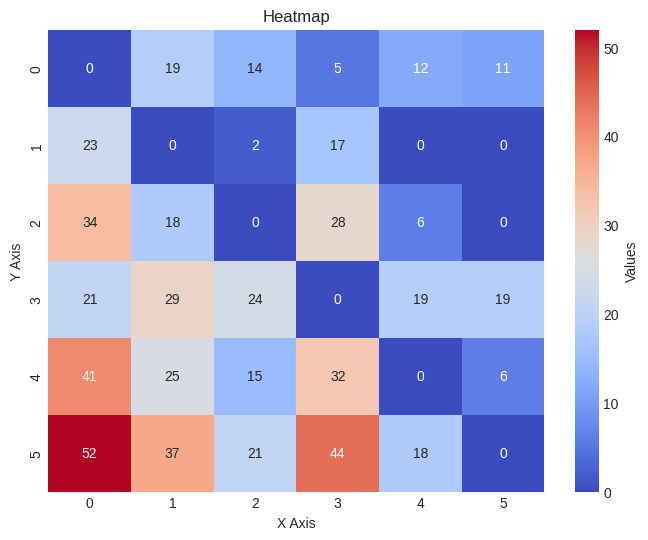

In [60]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(g, annot=True, cmap='coolwarm', fmt=".0f", cbar_kws={'label': 'Values'})
plt.title('Heatmap')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()


In [61]:
def fix_prompts(p):
    symbol = {'base': 'Base', 
    'sens_cats': 'SensCat', 
    'all_cats': 'SensCat+NonSensCat', 
    'base_sens': 'SensDesc', 
    'sens_cats_sens': 'SensCat+SensDesc', 
    'all_cats_sens': 'SensCat+NonSensCat+SensDesc', 
    'base_few': 'Base+FS', 
    'sens_cats_few': 'SensCat+FS', 
    'all_cats_few': 'SensCat+NonSensCat+FS', 
    'base_sens_few': 'Base+SensDesc+FS', 
    'sens_cats_sens_few': 'SensCat+SensDesc+FS', 
    'all_cats_sens_few': 'SensCat+NonSensCat+SensDesc+FS', 
    'all_cats_sens_hop1': 'SensCat+NonSensCat+SensDesc+CoT'}

    return symbol.get(p)


def get_graph_data(g):
    # Extract gains (feature correct, baseline incorrect) and losses (baseline correct, feature incorrect)
    losses = g[0, 1:]
    gains = g[1:, 0]

    # Define feature labels
    feature_labels = [compare[i] for i in range(1, 6)]
    feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

    feature_labels.reverse()
    gains = gains[::-1]
    losses = losses[::-1]
    return feature_labels, gains, losses

def plot1():
    # Create the diverging bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_labels, gains, color='green', label='Gains (Strategy correct, Baseline incorrect)')
    ax.barh(feature_labels, -losses, color='red', label='Losses (Baseline correct, Strategy incorrect)')
    ax.set_xlabel('Count')
    ax.set_title('Comparison of Prompting Strategies against Baseline')
    plt.legend()
    plt.show()


In [62]:
def plot2():
    # Enhanced color scheme and formatting
    colors_gains = ['#4daf4a']  # A shade of green
    colors_losses = ['#e41a1c']  # A shade of red

    # Create the diverging bar chart with improved aesthetics
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.5  # Adjust to change the bar thickness
    ax.barh(feature_labels, gains, color=colors_gains, label='Gains (Strategy correct, Baseline incorrect)', edgecolor='grey', height=bar_width)
    ax.barh(feature_labels, -losses, color=colors_losses, label='Losses (Baseline correct, Strategy incorrect)', edgecolor='grey', height=bar_width)

    ax.set_xlabel('Count')
    ax.set_title('Comparison of Prompting Strategies against Baseline')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False)  # Hide the ticks on the y-axis to reduce clutter
    plt.legend(frameon=False)  # No frame around the legend
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

In [63]:
feature_labels, gains, losses = get_graph_data(g)
print(feature_labels)

['SensCat+NonSensCat+SensDesc', 'SensCat+SensDesc', 'SensDesc', 'SensCat+NonSensCat', 'SensCat']


In [64]:
def fix_prompts(p):
    symbol = {'base': 'Base', 
    'sens_cats': 'SensCat', 
    'all_cats': 'SensCat+NonSensCat', 
    'base_sens': 'SensDesc', 
    'sens_cats_sens': 'SensCat+SensDesc', 
    'all_cats_sens': 'SensCat+NonSensCat+SensDesc', 
    'base_few': 'Base+FS', 
    'sens_cats_few': 'SensCat+FS', 
    'all_cats_few': 'SensCat+NonSensCat+FS', 
    'base_sens_few': 'Base+SensDesc+FS', 
    'sens_cats_sens_few': 'SensCat+SensDesc+FS', 
    'all_cats_sens_few': 'SensCat+NonSensCat+SensDesc+FS', 
    'all_cats_sens_hop1': 'SensCat+NonSensCat+SensDesc+CoT'}

    return symbol.get(p)


feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()

In [65]:
def best_plot(gains, losses, feature_labels):
    # Enhanced color scheme and formatting
    colors_gains = ['#76b7b2']  # A sophisticated shade of teal
    colors_losses = ['#f28e2b']  # A sophisticated shade of orange

    # Create the diverging bar chart with advanced aesthetics
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.5  # Bar thickness
    bars1 = ax.barh(feature_labels, gains, color=colors_gains, edgecolor='grey', height=bar_width, label='Gains (Strategy correct, Baseline incorrect)')
    bars2 = ax.barh(feature_labels, -losses, color=colors_losses, edgecolor='grey', height=bar_width, label='Losses (Baseline correct, Strategy incorrect)')

    ax.set_xlabel('Count', fontsize=12)
    ax.set_title('Comparison of Prompting Strategies against Baseline', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    ax.tick_params(axis='y', which='both', left=False)  # Hide the ticks on the y-axis
    plt.legend(frameon=True, fontsize=10)

    # Adding data labels at the end of the bars
    for bar in bars1 + bars2:
        width = bar.get_width()
        label_x_pos = width if width > 0 else width - 10
        text_x_pos = width + 0.5 if width > 0 else width - 0.5  # Adjust position inside or outside the bar
        ax.text(text_x_pos, bar.get_y() + bar.get_height() / 2., f'{int(abs(width))}', va='center', 
                ha='right' if width < 0 else 'left', fontsize=10, color='black' if width > 0 else 'black')

    plt.tight_layout()  # Adjust layout
    plt.show()

/tmp/ipykernel_23936/1644175059.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


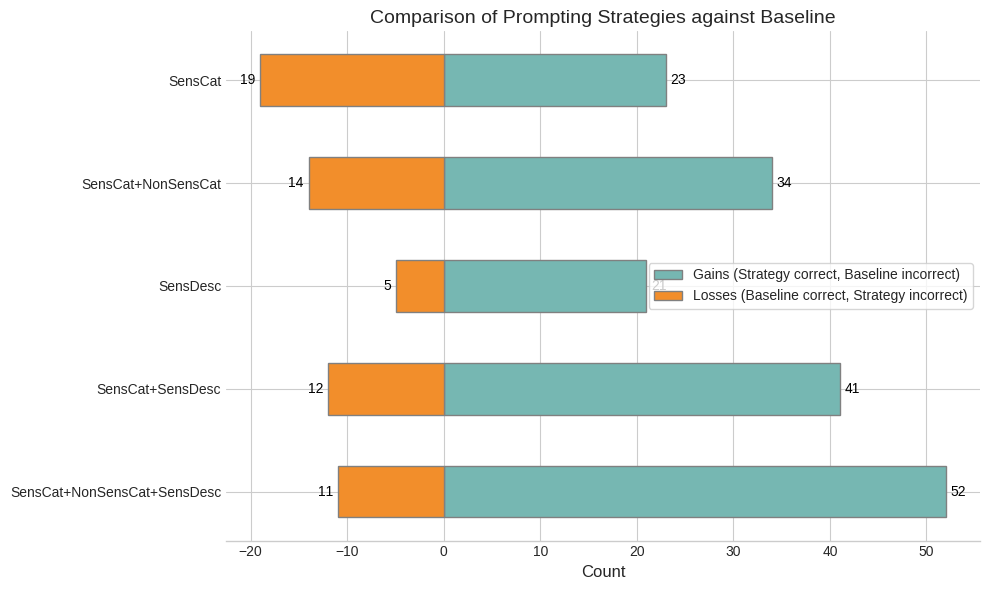

In [66]:
best_plot(gains, losses, feature_labels)

In [67]:
gains, losses, feature_labels

(array([52., 41., 21., 34., 23.]),
 array([11., 12.,  5., 14., 19.]),
 ['SensCat+NonSensCat+SensDesc',
  'SensCat+SensDesc',
  'SensDesc',
  'SensCat+NonSensCat',
  'SensCat'])

In [68]:

base_sign = [('base', 'sens_cats'), ('base', 'all_cats'), ('base', 'base_sens'), ('base', 'sens_cats_sens'), ('base', 'all_cats_sens')]
base_sign2 = [('sens_cats', 'all_cats'), ('sens_cats', 'sens_cats_sens'), ('all_cats', 'all_cats_sens'), ('sens_cats_sens', 'all_cats_sens')]

base_sign_fs = [('base', 'base_few'), ('base', 'sens_cats_few'), ('base', 'all_cats_few'), ('base', 'base_sens_few'), ('base', 'sens_cats_sens_few'), ('base', 'all_cats_sens_few')]
fs_sign = [('base', 'base_few'), ('sens_cats', 'sens_cats_few'), ('all_cats', 'all_cats_few'), ('base_sens', 'base_sens_few'), ('sens_cats_sens', 'sens_cats_sens_few'), ('all_cats_sens', 'all_cats_sens_few')]
base_sign_cot = [('base', 'all_cats_sens_hop1')]
cot_sign = [('all_cats_sens', 'all_cats_sens_hop1')]
compare = fs_sign

mapp = {'base':0, 'sens_cats':1, 'all_cats':2, 'base_sens':3, 'sens_cats_sens':4, 'all_cats_sens':5, 
        'base_few':6, 'sens_cats_few':7, 'all_cats_few':8, 'base_sens_few':9, 'sens_cats_sens_few':10, 'all_cats_sens_few':11,
        
        
        }
g = np.zeros((6,6))

improve_control = []
improve_change = []
for v in compare:
    prompt_name = v[0]
    prompt_name2 = v[1]
    instance_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
    improve_control.append(instance_stats[0][1])
    improve_change.append(instance_stats[1][0])


losses = np.array(improve_control)
gains = np.array(improve_change)


In [69]:
#feature_labels.append('Base')
#feature_labels = feature_labels[:6]
#feature_labels

/tmp/ipykernel_23936/1644175059.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (6,) and arg 3 with shape (5,).

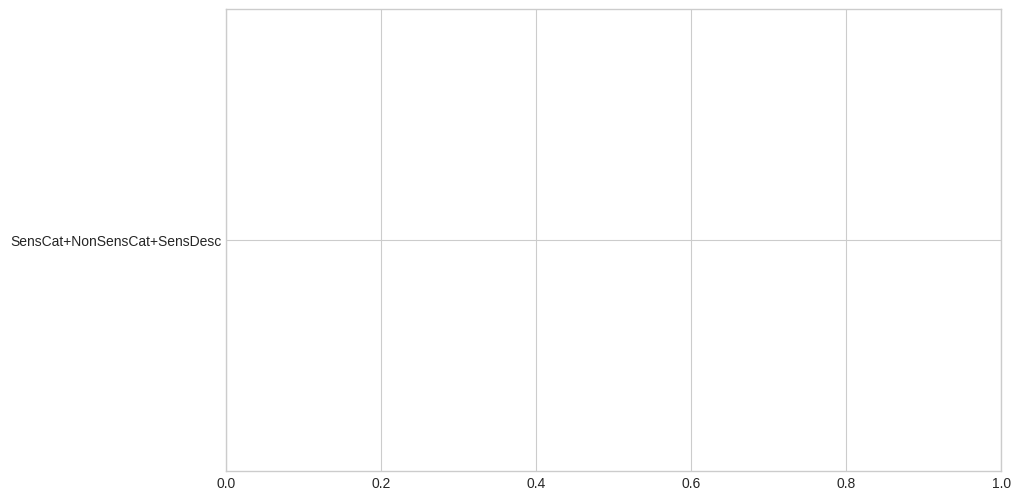

In [70]:
best_plot(gains, losses, feature_labels)

/tmp/ipykernel_23936/2684768928.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


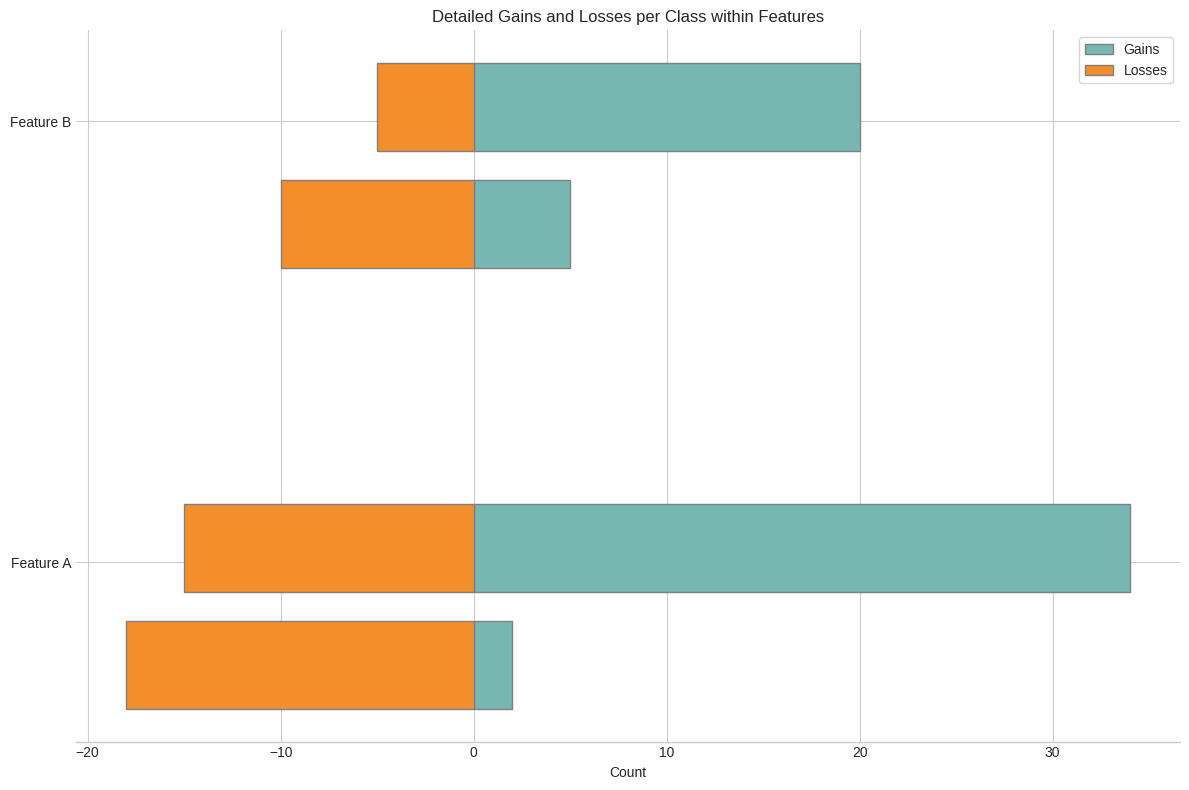

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76b7b2'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.3
    class_spacing = 0.1
    feature_spacing = 0.8

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        
        for class_data in feature:
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
            
            y_pos += bar_height + class_spacing
        
        # Append middle position of feature for y-axis labeling
        ticks.append((start_y + y_pos - class_spacing) / 2)
        tick_labels.append(label)
        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_title('Detailed Gains and Losses per Class within Features')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper right')

    plt.tight_layout()
    plt.show()

# Example data structured for multiple classes within each feature
data = [
    [{'gains': 2, 'losses': 18}, {'gains': 34, 'losses': 15}],  # Feature A: Class 0 and Class 1
    [{'gains': 5, 'losses': 10}, {'gains': 20, 'losses': 5}],   # Feature B: Class 0 and Class 1
]
feature_labels = ['Feature A', 'Feature B']

best_plot(data, feature_labels)


/tmp/ipykernel_23936/98483389.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


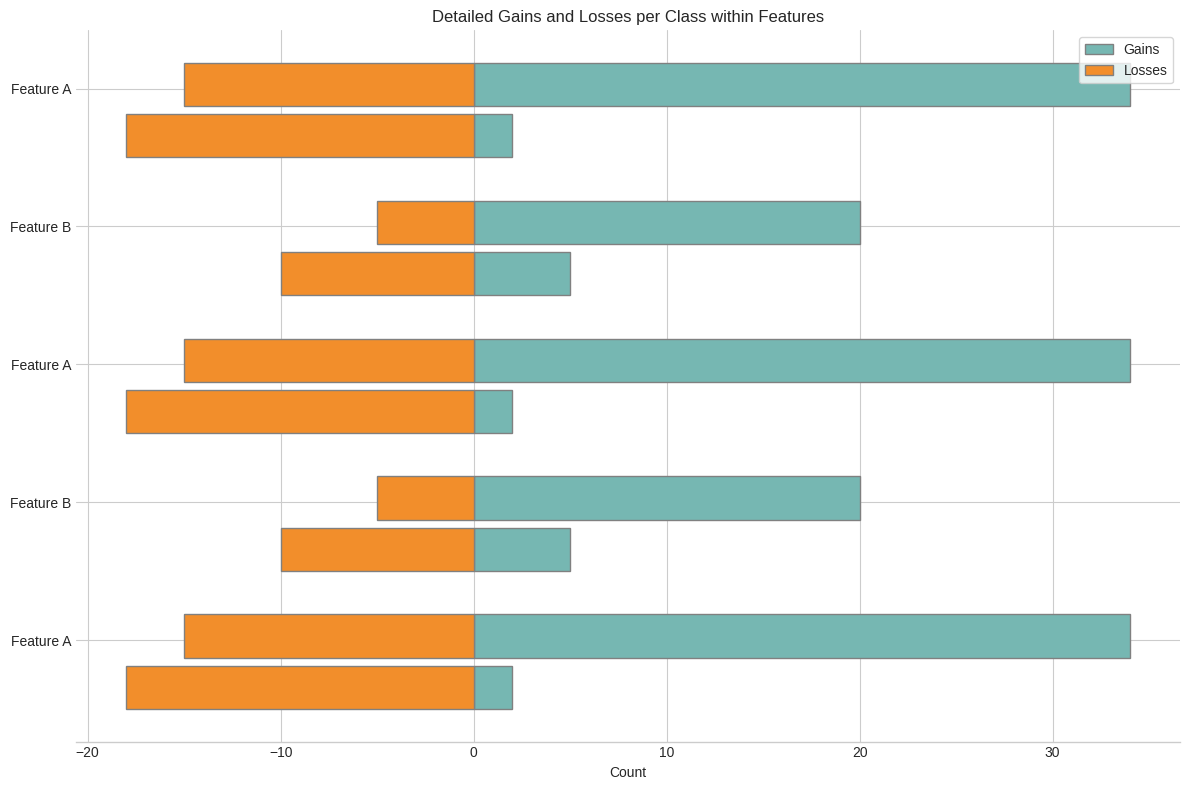

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76b7b2'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.05  # Make bars skinnier
    class_spacing = 0.01
    feature_spacing = 0.05

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        
        for class_data in feature:
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
            
            y_pos += bar_height + class_spacing
        
        # Adjust the tick position to better align with the center of the bars
        ticks.append((start_y + y_pos - class_spacing) / 2)
        tick_labels.append(label)
        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_title('Detailed Gains and Losses per Class within Features')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper right')

    plt.tight_layout()
    plt.show()

# Example data structured for multiple classes within each feature
data = [
    # Class 0, Class 1
    [{'gains': 2, 'losses': 18}, {'gains': 34, 'losses': 15}],  # Feature A: Class 0 and Class 1
    [{'gains': 5, 'losses': 10}, {'gains': 20, 'losses': 5}],   # Feature B: Class 0 and Class 1
    [{'gains': 2, 'losses': 18}, {'gains': 34, 'losses': 15}],  # Feature A: Class 0 and Class 1
    [{'gains': 5, 'losses': 10}, {'gains': 20, 'losses': 5}],   # Feature B: Class 0 and Class 1
    [{'gains': 2, 'losses': 18}, {'gains': 34, 'losses': 15}],  # Feature A: Class 0 and Class 1
    [{'gains': 5, 'losses': 10}, {'gains': 20, 'losses': 5}],   # Feature B: Class 0 and Class 1
    [{'gains': 2, 'losses': 18}, {'gains': 34, 'losses': 15}],  # Feature A: Class 0 and Class 1
]
feature_labels = ['Feature A', 'Feature B', 'Feature A', 'Feature B', 'Feature A']

best_plot(data, feature_labels)


In [73]:
def get_graph_data(g):
    # Extract gains (feature correct, baseline incorrect) and losses (baseline correct, feature incorrect)
    losses = g[0, 1:]
    gains = g[1:, 0]

    # Define feature labels
    feature_labels = [compare[i] for i in range(1, 6)]
    feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

    feature_labels.reverse()
    gains = gains[::-1]
    losses = losses[::-1]
    return feature_labels, gains, losses

In [74]:

non_g = np.zeros((6,6))
sen_g = np.zeros((6,6))

def mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, df):
    results_df = df[(df.model == model_name) | (df.model == model_name2)]
    overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)
    non_results_df = df[df['ground_truth'] == 0]
    non_table = mc_eval_util_both(non_results_df, prompt_name, prompt_name2, model_name, model_name2)
    sen_results_df = df[df['ground_truth'] == 1]
    sen_table = mc_eval_util_both(sen_results_df, prompt_name, prompt_name2, model_name, model_name2)

    #print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    #print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))

    return non_table, sen_table #overall_table

def non_jj(x, p1, p2):
    improve_control = x[0, 1]
    improve_change = x[1, 0]
    non_g[mapp.get(p1), mapp.get(p2)] = improve_control
    non_g[mapp.get(p2), mapp.get(p1)] = improve_change

def sen_jj(x, p1, p2):
    improve_control = x[0, 1]
    improve_change = x[1, 0]
    sen_g[mapp.get(p1), mapp.get(p2)] = improve_control
    sen_g[mapp.get(p2), mapp.get(p1)] = improve_change


compare = list(mapp.keys())[:6]
for i, v in enumerate(compare):
    for v1 in compare[(i+1):]:
        prompt_name = v
        prompt_name2 = v1
        non_stats, sens_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df) #[all_results_df.ground_truth==1])
        non_jj(np.array(non_stats), prompt_name, prompt_name2)
        sen_jj(np.array(sens_stats), prompt_name, prompt_name2)


    break


print(non_g)
print(sen_g)


[[  0.  22.  41.  65.  52.  61.]
 [135.   0.   0.   0.   0.   0.]
 [127.   0.   0.   0.   0.   0.]
 [ 32.   0.   0.   0.   0.   0.]
 [134.   0.   0.   0.   0.   0.]
 [123.   0.   0.   0.   0.   0.]]
[[ 0. 19. 14.  5. 12. 11.]
 [23.  0.  0.  0.  0.  0.]
 [34.  0.  0.  0.  0.  0.]
 [21.  0.  0.  0.  0.  0.]
 [41.  0.  0.  0.  0.  0.]
 [52.  0.  0.  0.  0.  0.]]


In [75]:
mapp

{'base': 0,
 'sens_cats': 1,
 'all_cats': 2,
 'base_sens': 3,
 'sens_cats_sens': 4,
 'all_cats_sens': 5,
 'base_few': 6,
 'sens_cats_few': 7,
 'all_cats_few': 8,
 'base_sens_few': 9,
 'sens_cats_sens_few': 10,
 'all_cats_sens_few': 11}

In [76]:
for v in non_g:
    print(v)

[ 0. 22. 41. 65. 52. 61.]
[135.   0.   0.   0.   0.   0.]
[127.   0.   0.   0.   0.   0.]
[32.  0.  0.  0.  0.  0.]
[134.   0.   0.   0.   0.   0.]
[123.   0.   0.   0.   0.   0.]


In [88]:
tuples_list = [[{'gains': sen_g[i,0], 'losses': sen_g[0,i]}, {'gains': non_g[i,0], 'losses': non_g[0,i]}] for i in range(1, len(non_g))]
print(tuples_list)

[[{'gains': 23.0, 'losses': 19.0}, {'gains': 135.0, 'losses': 22.0}], [{'gains': 34.0, 'losses': 14.0}, {'gains': 127.0, 'losses': 41.0}], [{'gains': 21.0, 'losses': 5.0}, {'gains': 32.0, 'losses': 65.0}], [{'gains': 41.0, 'losses': 12.0}, {'gains': 134.0, 'losses': 52.0}], [{'gains': 52.0, 'losses': 11.0}, {'gains': 123.0, 'losses': 61.0}]]


/tmp/ipykernel_23936/1221098383.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


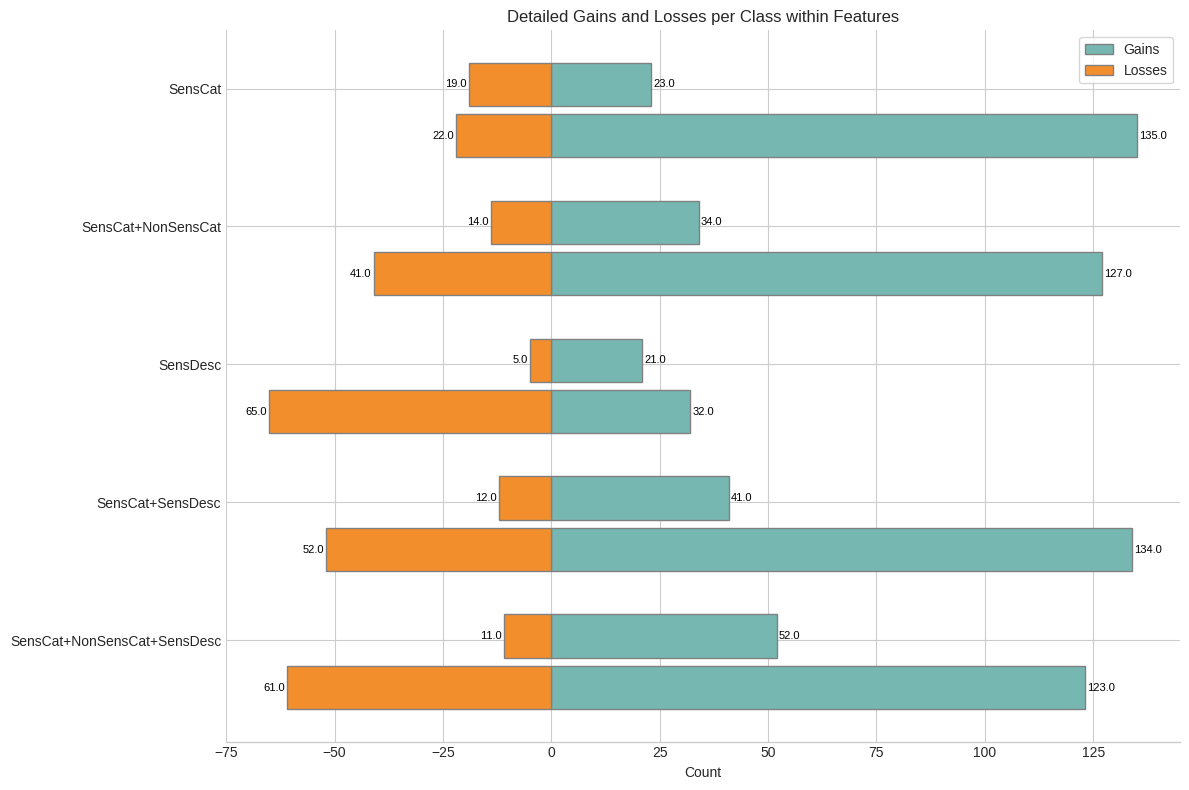

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76b7b2'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.05  # Make bars skinnier
    class_spacing = 0.01
    feature_spacing = 0.05

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        
        for class_data in feature:
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
        
            # Adding labels on gains
            ax.text(gains + 0.5, y_pos, f'{gains}', va='center', ha='left', fontsize=8, color='black')
            # Adding labels on losses
            ax.text(-losses - 0.5, y_pos, f'{losses}', va='center', ha='right', fontsize=8, color='black')

            y_pos += bar_height + class_spacing
        
        # Adjust the tick position to better align with the center of the bars
        ticks.append((start_y + y_pos - class_spacing) / 2)
        tick_labels.append(label)
        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_title('Detailed Gains and Losses per Class within Features')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper right')


    plt.tight_layout()  # Adjust layout
    plt.show()

# Example data structured for multiple classes within each feature
data = tuples_list
data.reverse()
feature_labels = ['Feature A', 'Feature B', 'Feature A', 'Feature B', 'Feature A']
feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()
best_plot(data, feature_labels)


/tmp/ipykernel_23936/55431368.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


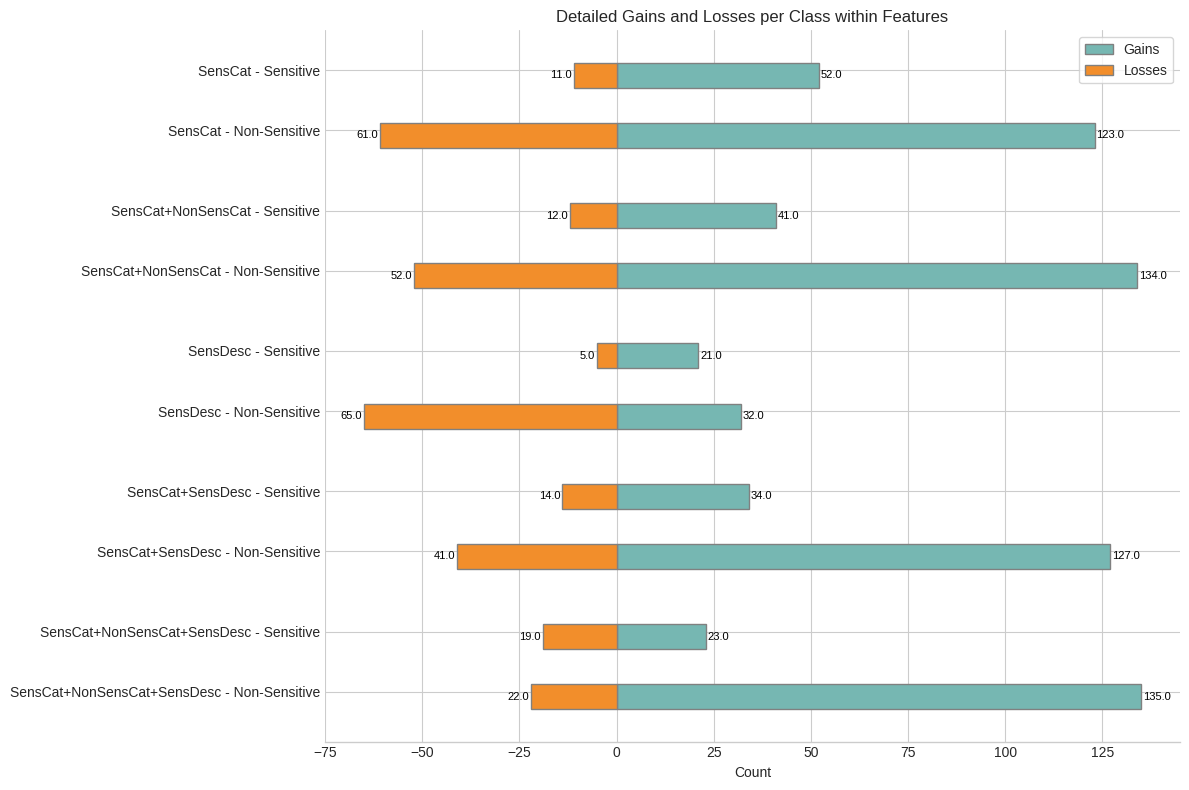

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76b7b2'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.05  # Make bars skinnier
    class_spacing = 0.01
    feature_spacing = 0.05

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        class_labels = ['Non-Sensitive', 'Sensitive']  # Class labels
        
        for class_idx, class_data in enumerate(feature):
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
        
            # Adding labels on gains
            ax.text(gains + 0.5, y_pos, f'{gains}', va='center', ha='left', fontsize=8, color='black')
            # Adding labels on losses
            ax.text(-losses - 0.5, y_pos, f'{losses}', va='center', ha='right', fontsize=8, color='black')

            y_pos += bar_height + class_spacing
        
        # Adjust the tick position to better align with the center of the bars
            ticks.append((y_pos-0.05))
            tick_labels.append(f'{label} - {class_labels[class_idx]}')

            y_pos += bar_height + class_spacing  # Increment y position for the next bar

        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_title('Detailed Gains and Losses per Class within Features')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper right')


    plt.tight_layout()  # Adjust layout
    plt.show()

# Example data structured for multiple classes within each feature
data = tuples_list
data.reverse()
feature_labels = ['Feature A', 'Feature B', 'Feature A', 'Feature B', 'Feature A']
feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()
best_plot(data, feature_labels)


In [80]:
tuples_list
tuples_list.reverse()
tuples_list

[[{'gains': 123.0, 'losses': 61.0}, {'gains': 52.0, 'losses': 11.0}],
 [{'gains': 134.0, 'losses': 52.0}, {'gains': 41.0, 'losses': 12.0}],
 [{'gains': 32.0, 'losses': 65.0}, {'gains': 21.0, 'losses': 5.0}],
 [{'gains': 127.0, 'losses': 41.0}, {'gains': 34.0, 'losses': 14.0}],
 [{'gains': 135.0, 'losses': 22.0}, {'gains': 23.0, 'losses': 19.0}]]

In [81]:
feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()
feature_labels

['SensCat+NonSensCat+SensDesc',
 'SensCat+SensDesc',
 'SensDesc',
 'SensCat+NonSensCat',
 'SensCat']

/tmp/ipykernel_23936/3826728927.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


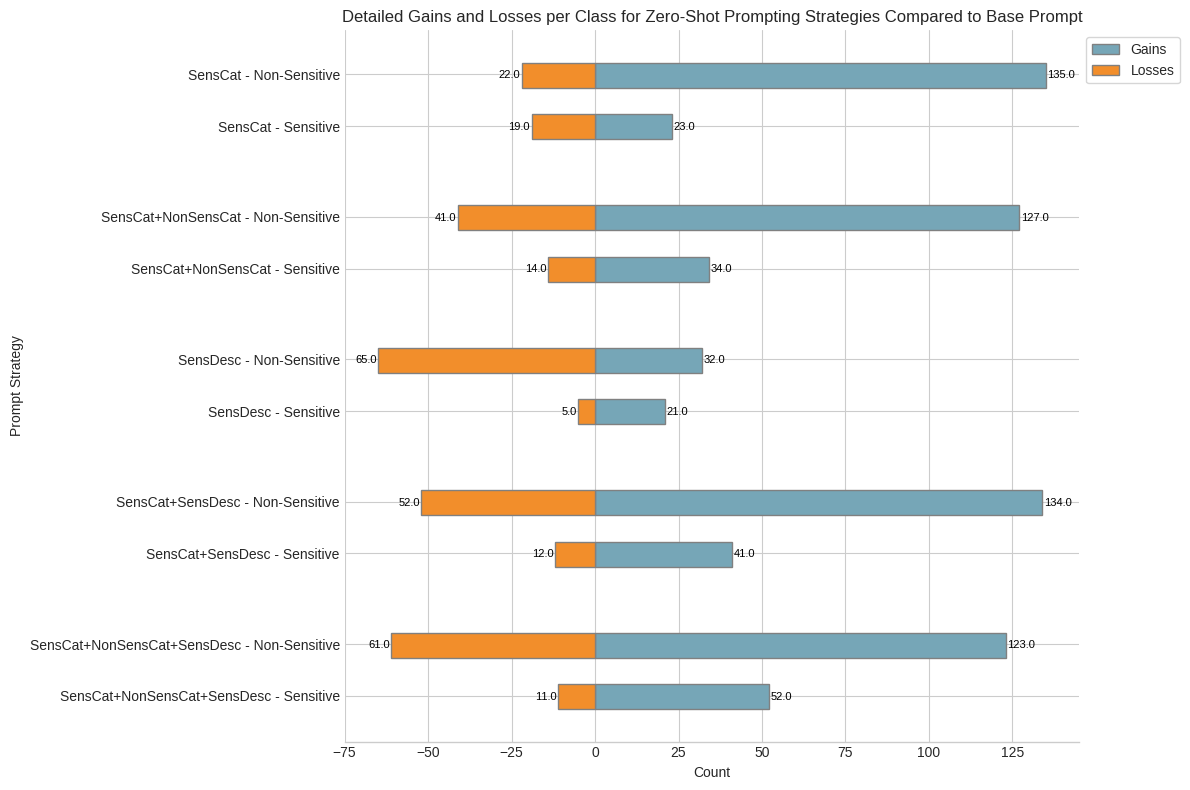

In [138]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76a6b7'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.05  # Make bars skinnier
    class_spacing = 0.0015
    feature_spacing = 0.08

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        class_labels = ['Sensitive', 'Non-Sensitive']  # Class labels
        
        for class_idx, class_data in enumerate(feature):
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
        
            # Adding labels on gains
            ax.text(gains + 0.5, y_pos, f'{gains}', va='center', ha='left', fontsize=8, color='black')
            # Adding labels on losses
            ax.text(-losses - 0.5, y_pos, f'{losses}', va='center', ha='right', fontsize=8, color='black')

            y_pos += bar_height + class_spacing
        
        # Adjust the tick position to better align with the center of the bars
            ticks.append((y_pos-0.05))
            tick_labels.append(f'{label} - {class_labels[class_idx]}')

            y_pos += bar_height + class_spacing  # Increment y position for the next bar

        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_ylabel('Prompt Strategy')
    ax.set_title('Detailed Gains and Losses per Class for Zero-Shot Prompting Strategies Compared to Base Prompt')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1,1))


    plt.tight_layout()  # Adjust layout
    plt.show()

# Example data structured for multiple classes within each feature
data = tuples_list
data.reverse()
feature_labels = ['Feature A', 'Feature B', 'Feature A', 'Feature B', 'Feature A']
feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()
best_plot(data, feature_labels)


In [84]:
[[ 0. 19. 14.  5. 12. 11.]
 [23.  0.  0.  0.  0.  0.]
 [34.  0.  0.  0.  0.  0.]
 [21.  0.  0.  0.  0.  0.]
 [41.  0.  0.  0.  0.  0.]
 [52.  0.  0.  0.  0.  0.]]

SyntaxError: invalid syntax (3076289628.py, line 1)

/tmp/ipykernel_23936/3041361322.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


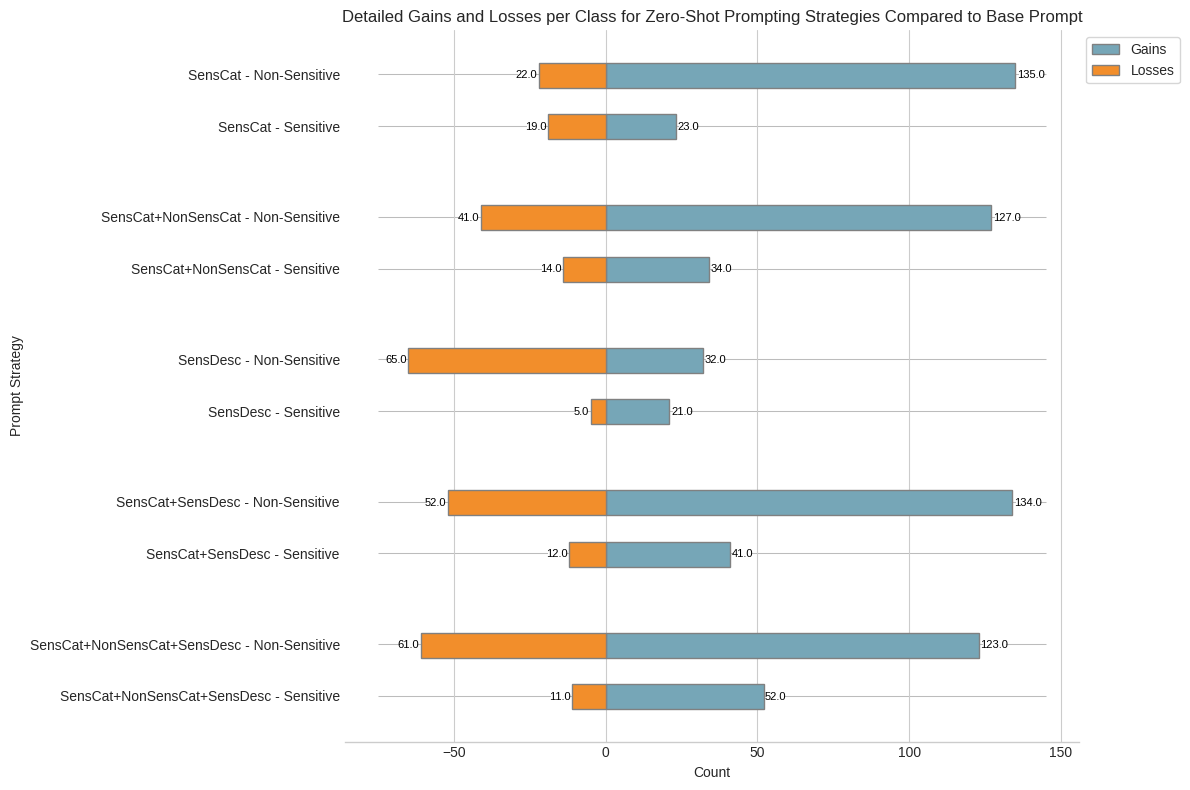

In [188]:
import matplotlib.pyplot as plt
import numpy as np

def best_plot(data, feature_labels):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colors for gains and losses
    colors_gains = '#76a6b7'
    colors_losses = '#f28e2b'

    # Vertical spacing and width of each bar
    bar_height = 0.05  # Make bars skinnier
    class_spacing = 0.0015
    feature_spacing = 0.08

    # Initialize y position
    y_pos = 0

    # Tick positions and labels for the y-axis
    ticks = []
    tick_labels = []
    grid_line_positions = []

    for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
        class_count = len(feature)
        start_y = y_pos
        class_labels = ['Sensitive', 'Non-Sensitive']  # Class labels
        
        for class_idx, class_data in enumerate(feature):
            gains = class_data['gains']
            losses = class_data['losses']
            
            # Plot gains for the class
            ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
            # Plot losses for the class
            ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
        
            # Adding labels on gains
            ax.text(gains + 0.5, y_pos, f'{gains}', va='center', ha='left', fontsize=8, color='black', zorder=5, bbox=dict(facecolor='white', edgecolor='none', pad=-1.5))
            # Adding labels on losses
            ax.text(-losses - 0.5, y_pos, f'{losses}', va='center', ha='right', fontsize=8, color='black', zorder=5, bbox=dict(facecolor='white', edgecolor='none', pad=-1.5))

            y_pos += bar_height + class_spacing
        
        # Adjust the tick position to better align with the center of the bars
            ticks.append((y_pos-0.05))
            tick_labels.append(f'{label} - {class_labels[class_idx]}')
            grid_line_positions.append((y_pos-0.05))

            #ticks.append((y_pos-0.1))
            #tick_labels.append(f'{label}                          ')


            y_pos += bar_height + class_spacing  # Increment y position for the next bar

        y_pos += feature_spacing - class_spacing  # Add extra spacing between features

    ax.set_xlabel('Count')
    ax.set_ylabel('Prompt Strategy')
    ax.set_title('Detailed Gains and Losses per Class for Zero-Shot Prompting Strategies Compared to Base Prompt')
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1,1))

    ax.grid(False, axis='y')
    ax.hlines(grid_line_positions, *ax.get_xlim(), colors='#BCBCBC', linestyles='solid', zorder=0, linewidth=0.75)


    plt.tight_layout()  # Adjust layout
    plt.show()

# Example data structured for multiple classes within each feature
data = tuples_list
data.reverse()
feature_labels = ['Feature A', 'Feature B', 'Feature A', 'Feature B', 'Feature A']
feature_labels = [fix_prompts(compare[i]) for i in range(1, 6)]

feature_labels.reverse()
best_plot(data, feature_labels)


FinalAnalaysisCharts

In [269]:
def analysis_charts(compare, model_name, model_name2, all_results_df, title, fname):
    size = len(compare)
    non_g = np.zeros((size,size))
    sen_g = np.zeros((size,size))

    def mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, df):
        results_df = df[(df.model == model_name) | (df.model == model_name2)]
        overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)
        non_results_df = df[df['ground_truth'] == 0]
        non_table = mc_eval_util_both(non_results_df, prompt_name, prompt_name2, model_name, model_name2)
        sen_results_df = df[df['ground_truth'] == 1]
        sen_table = mc_eval_util_both(sen_results_df, prompt_name, prompt_name2, model_name, model_name2)

        #print('Overall\t\t Non-sensitive only\t Sensitive only')
        #print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
        #print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))

        return non_table, sen_table #overall_table

    def non_jj(x, i):
        improve_control = x[0, 1]
        improve_change = x[1, 0]
        non_g[0, i] = improve_control
        non_g[i, 0] = improve_change

    def sen_jj(x, i):
        improve_control = x[0, 1]
        improve_change = x[1, 0]
        sen_g[0, i] = improve_control
        sen_g[i, 0] = improve_change


    def analysis_plot(data, feature_labels):
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        # Colors for gains and losses
        colors_gains = '#76a6b7'
        colors_losses = '#f28e2b'

        # Vertical spacing and width of each bar
        bar_height = 0.05  # Make bars skinnier
        class_spacing = 0.0015
        feature_spacing = 0.08

        # Initialize y position
        y_pos = 0

        # Tick positions and labels for the y-axis
        ticks = []
        tick_labels = []
        grid_line_positions = []

        for feature_idx, (feature, label) in enumerate(zip(data, feature_labels)):
            class_count = len(feature)
            start_y = y_pos
            class_labels = ['Sensitive', 'Non-Sensitive']  # Class labels
            
            for class_idx, class_data in enumerate(feature):
                gains = class_data['gains']
                losses = class_data['losses']
                
                # Plot gains for the class
                ax.barh(y_pos, gains, height=bar_height, color=colors_gains, edgecolor='grey', label='Gains' if feature_idx == 0 and y_pos == 0 else "")
                # Plot losses for the class
                ax.barh(y_pos, -losses, height=bar_height, color=colors_losses, edgecolor='grey', label='Losses' if feature_idx == 0 and y_pos == 0 else "")
            
                # Adding labels on gains
                ax.text(gains + 0.5, y_pos, f'{gains}', va='center', ha='left', fontsize=8, color='black', zorder=5, bbox=dict(facecolor='white', edgecolor='none', pad=-1.5))
                # Adding labels on losses
                ax.text(-losses - 0.5, y_pos, f'{losses}', va='center', ha='right', fontsize=8, color='black', zorder=5, bbox=dict(facecolor='white', edgecolor='none', pad=-1.5))

                y_pos += bar_height + class_spacing
            
            # Adjust the tick position to better align with the center of the bars
                ticks.append((y_pos-0.05))
                tick_labels.append(f'{label} - {class_labels[class_idx]}')
                grid_line_positions.append((y_pos-0.05))

                #ticks.append((y_pos-0.1))
                #tick_labels.append(f'{label}                          ')


                y_pos += bar_height + class_spacing  # Increment y position for the next bar

            y_pos += feature_spacing - class_spacing  # Add extra spacing between features

        ax.set_xlabel('Gain/Loss in Documents Classified')
        ax.set_ylabel('Prompt Strategy')
        ax.set_title((fix_name(model_name)+' - '+title)) #'Detailed Gains and Losses per Class for Zero-Shot Prompting Strategies Compared to Base Prompt')
        ax.set_yticks(ticks)
        ax.set_yticklabels(tick_labels)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1,1))

        ax.grid(False, axis='y')
        ax.hlines(grid_line_positions, *ax.get_xlim(), colors='#BCBCBC', linestyles='solid', zorder=0, linewidth=0.75)


        plt.tight_layout()  # Adjust layout
        plt.savefig(model_name+f'-{fname}.pdf', dpi=600)
        #plt.show()

    
    # Main
    for i, v in enumerate(compare):
        prompt_name = v[0]
        prompt_name2 = v[1]
        non_stats, sens_stats = mcnemar_eval_table_out(model_name, model_name2, prompt_name, prompt_name2, all_results_df) #[all_results_df.ground_truth==1])
        non_jj(np.array(non_stats), i)
        sen_jj(np.array(sens_stats), i)

    tuples_list = [[{'gains': sen_g[i,0], 'losses': sen_g[0,i]}, {'gains': non_g[i,0], 'losses': non_g[0,i]}] for i in range(1, len(non_g))]
    #print(tuples_list)

    data = tuples_list
    data.reverse()
    feature_labels = [fix_prompts(compare[i][1]) for i in range(1, 6)]

    feature_labels.reverse()
    analysis_plot(data, feature_labels)


/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the se

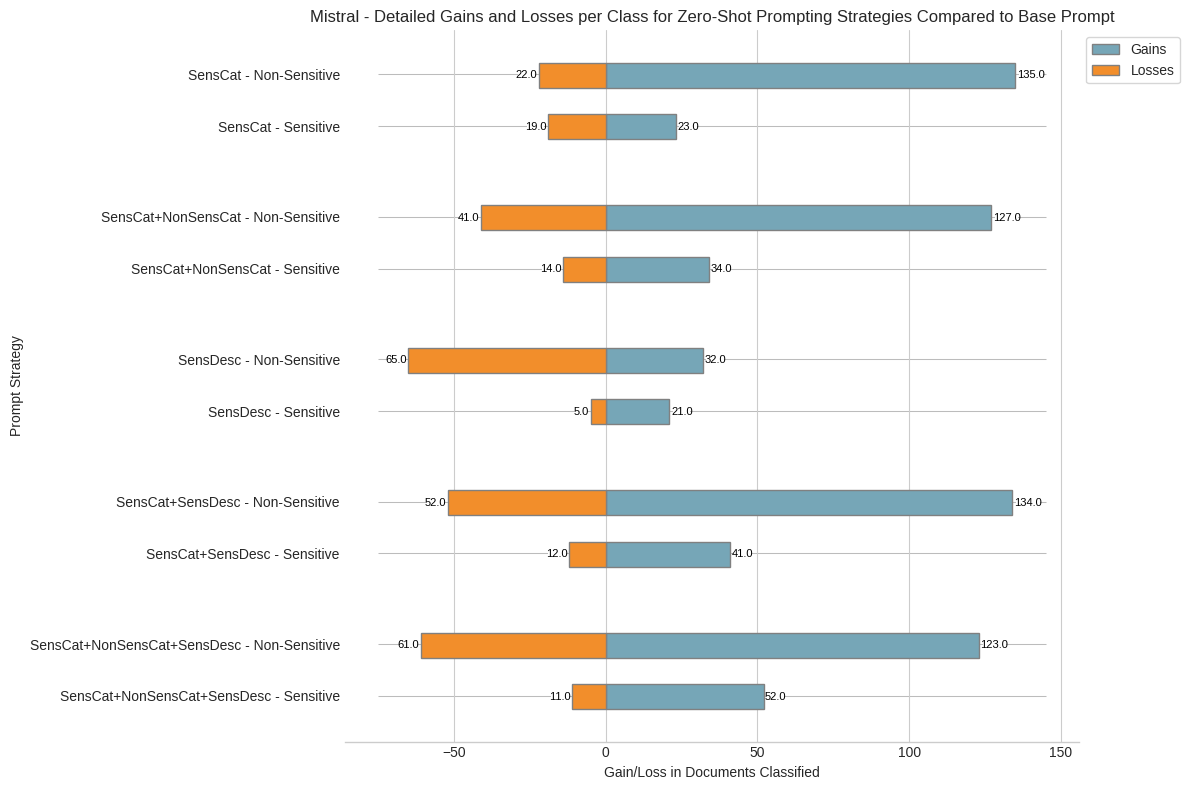

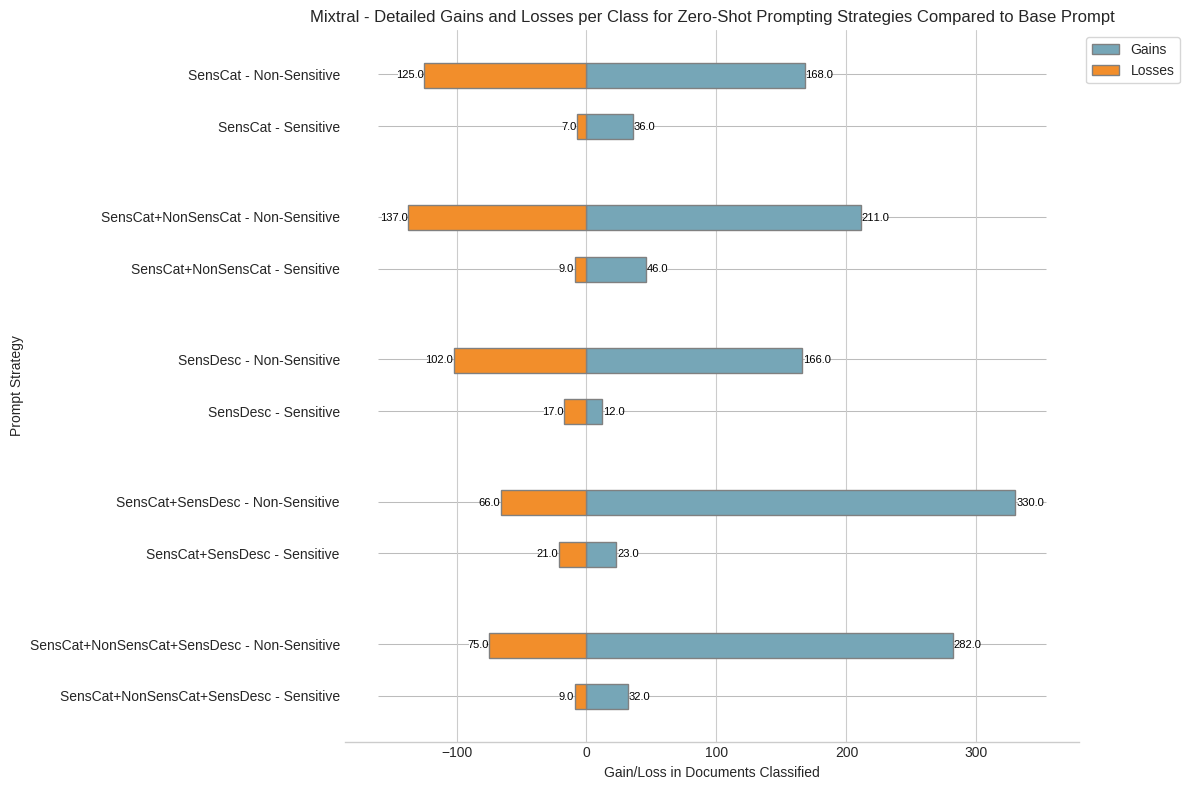

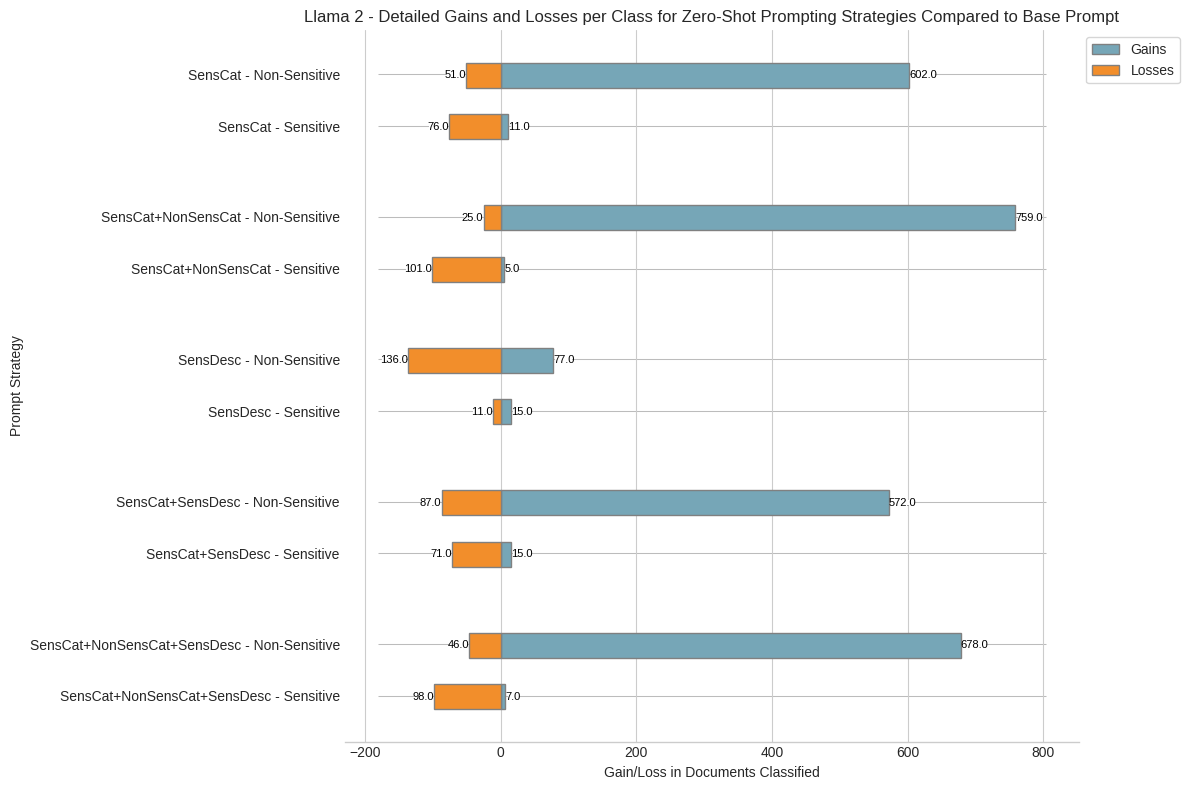

In [270]:
compare = [('base', 'base'), ('base', 'sens_cats'), ('base', 'all_cats'), ('base', 'base_sens'), ('base', 'sens_cats_sens'), ('base', 'all_cats_sens')]
m_list = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
for m in m_list:
    analysis_charts(compare, m, m, all_results_df, 'Detailed Gains and Losses per Class for Zero-Shot Prompting Strategies Compared to Base Prompt', 'zeroshot')

/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_23936/3813367712.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the se

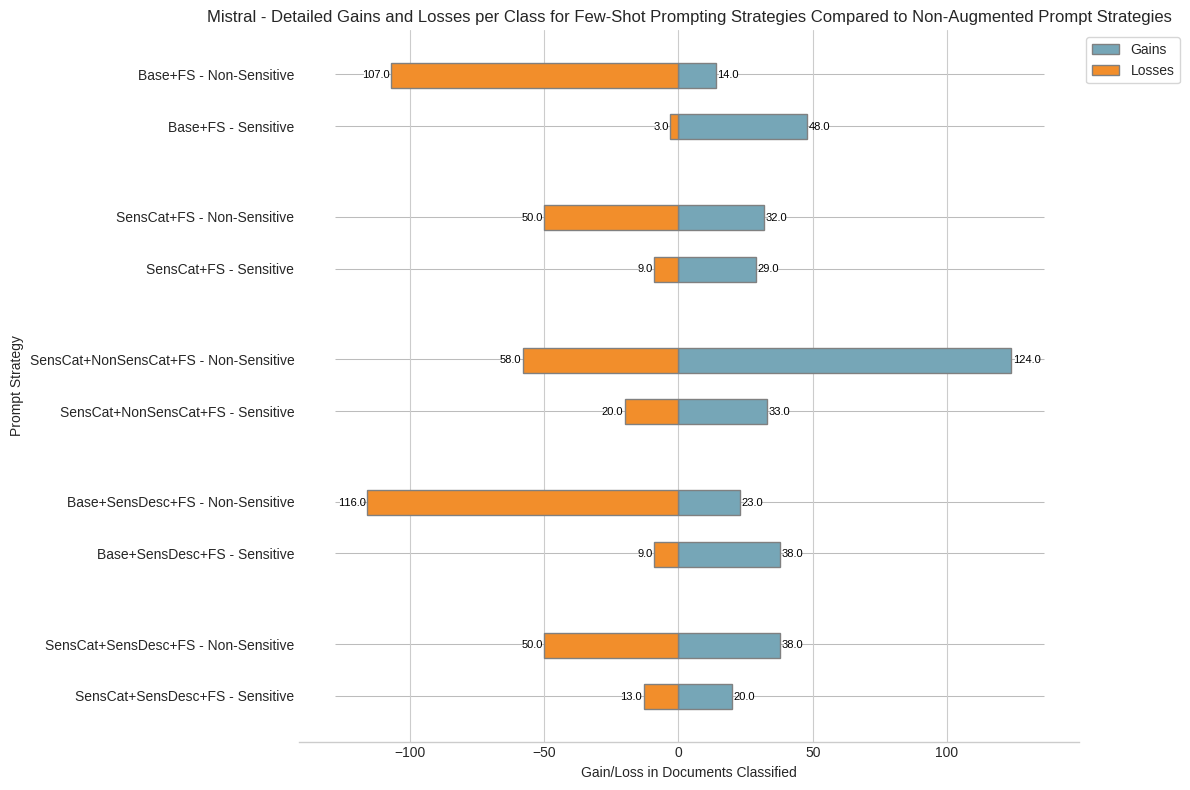

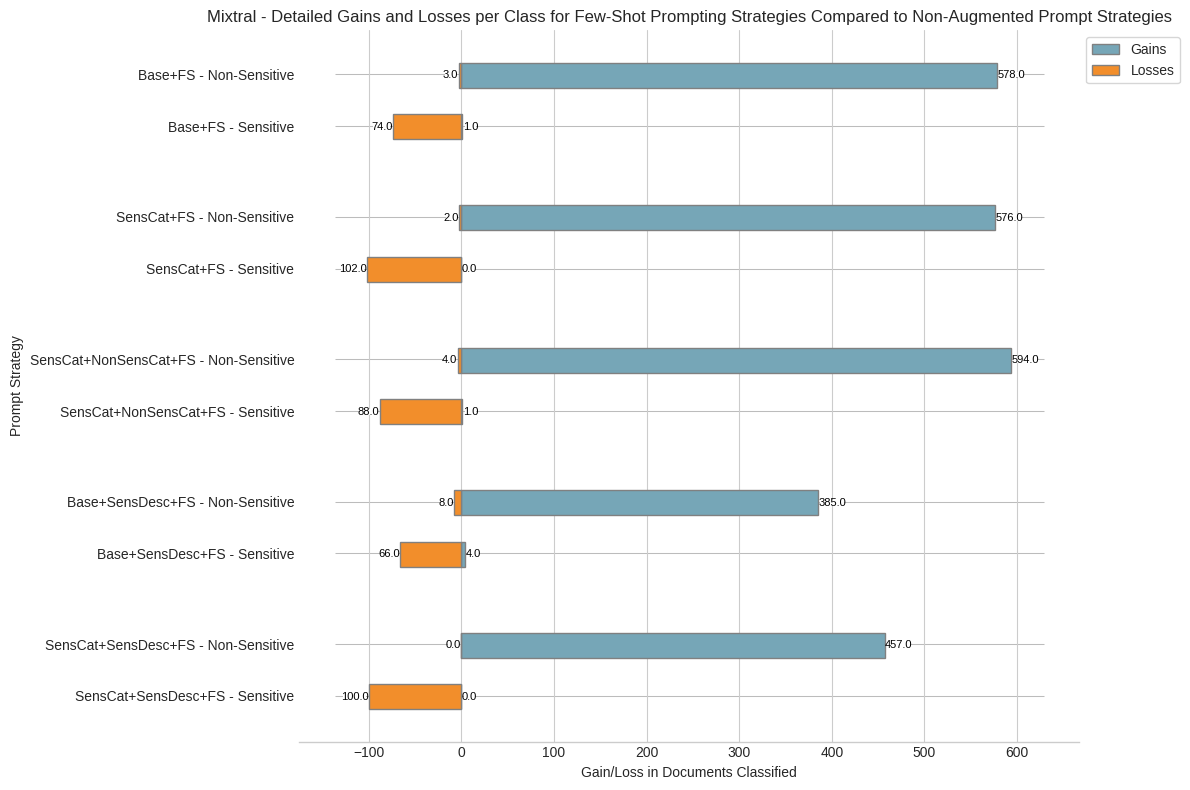

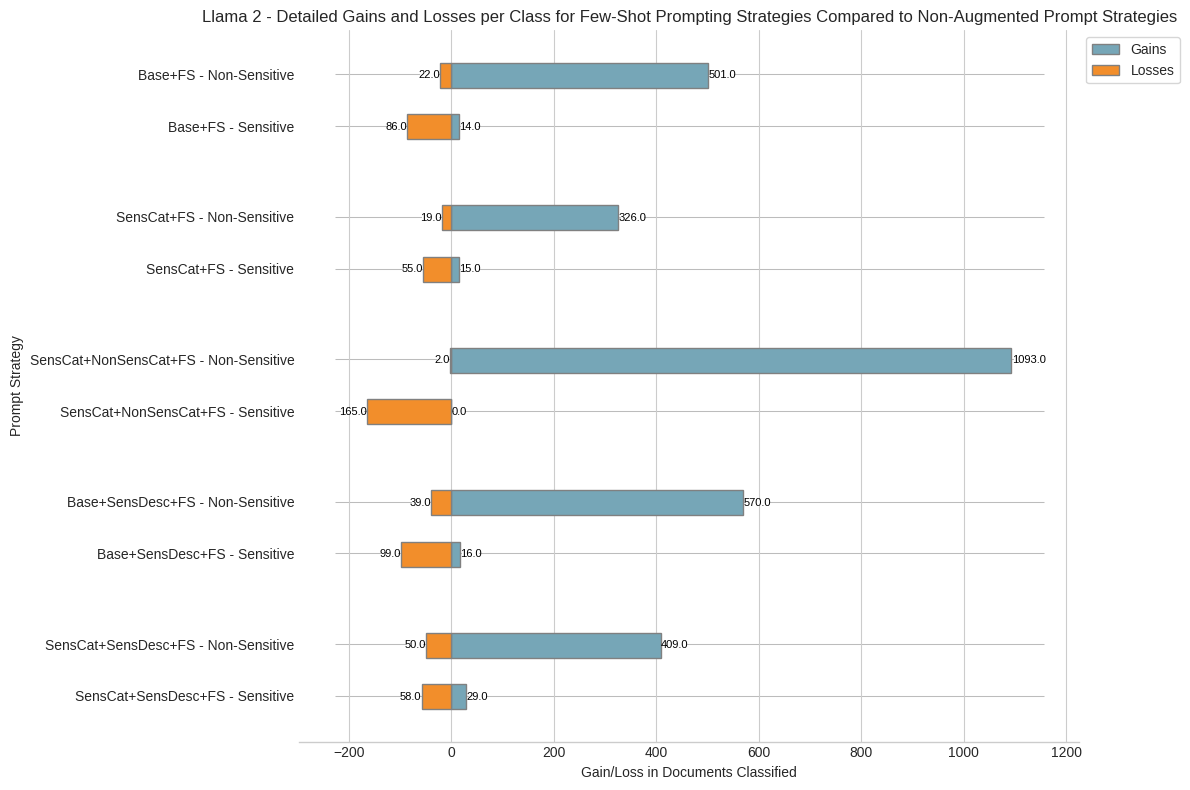

In [271]:
compare = [('base', 'base'), ('base', 'base_few'), ('sens_cats', 'sens_cats_few'), ('all_cats', 'all_cats_few'), ('base_sens', 'base_sens_few'), ('sens_cats_sens', 'sens_cats_sens_few'), ('all_cats_sens', 'all_cats_sens_few')]
m_list = ['mist-noreply', 'mixt-noreply', 'l27b-noreply']
for m in m_list:
    analysis_charts(compare, m, m, all_results_df, 'Detailed Gains and Losses per Class for Few-Shot Prompting Strategies Compared to Non-Augmented Prompt Strategies', 'fewshot')

### Document Comparison

In [31]:
def prev_doc_comparison():
    # Eval config
    all_results_df = get_results_json('flanxl-noreply', clean=False)
    #all_results_df = all_results_df[all_results_df.prompt == 'cg']


    model_name = 'flanxl-noreply'
    prompt_name_control = 'pdc'
    prompt_name_change = 'cg'
    truth_lab = 1
    model_guess = 1

    rdf = all_results_df
    rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
    df = rdf_truth_select[(rdf_truth_select.model == model_name) & ((rdf_truth_select.prompt == prompt_name_control) |  (rdf_truth_select.prompt == prompt_name_change))]
    guess_df = df[df.prediction == model_guess] #.doc_id.to_list()
    diff_guess_df = guess_df.groupby('doc_id').filter(lambda x: x['prompt'].nunique() == 1)
    id_diff_guesses = diff_guess_df.doc_id.to_list()

    current_directory = os.getcwd()
    file_path = os.path.join(current_directory, f'scripts/results/model_results/{model_name}/{prompt_name_control}/all_responses.json')
    #print("Path to results", file_path)

    genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]
    s = load_sara()
    filtered_df = s[s['doc_id'].isin(id_diff_guesses)]
    # use map for tokenizer
    filtered_df = full_preproc(filtered_df, model_name)

    sum = 0
    for i, tex in enumerate(filtered_df.iterrows()):
        idd = tex[1].doc_id
        text = tex[1].text
        sens = tex[1].sensitivity
        control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
        pred_control = control_row.prediction.iloc[0]
        gen_control = control_row.generated_response.iloc[0]
        change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
        pred_change = change_row.prediction.iloc[0]
        gen_change = change_row.generated_response.iloc[0]

        # Only show agreement/disagreement documents
        #if gen_pred_change == truth_lab:
        #if pred_change == pred_control:
        #    print(1)
        #    continue
        if pred_change == 0 or pred_control == 0:
            continue

        print('DOCUMENT VIEW')
        print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(email_genre_map.get(idd)), '\nMessage:')
        print(text)
        print(s[s.doc_id == idd].iloc[0].text)
        print('End Message.')
        print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
        print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
        #print('Verbose desc:', verb)
        print('\n\n')
        
        #if i == 4:
        #    break


In [42]:
s = load_sara()
#filtered_df = s
# use map for tokenizer
all_results_df = get_results_json('mist-noreply-verbose', clean=False)
filtered_df = full_preproc(s, 'mist-noreply')

In [43]:
# Eval config
#all_results_df = get_results_json('mist-noreply', clean=False)
#all_results_df = all_results_df[all_results_df.prompt == 'cg']

model_name = 'mist-noreply-verbose'
prompt_name_control = 'all_cats'
prompt_name_change = 'all_cats_sens'
truth_lab = 1
model_guess_control = 1
model_guess_change = 1

genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]


In [46]:
def doc_comparisons(filtered_df):
    for i, tex in enumerate(filtered_df.iterrows()):
        idd = tex[1].doc_id
        text = tex[1].text
        sens = tex[1].sensitivity
        control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
        pred_control = 2 #control_row.prediction.iloc[0]
        gen_control = control_row.generated_response.iloc[0]
        change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
        pred_change = 2 #change_row.prediction.iloc[0]
        gen_change = change_row.generated_response.iloc[0]

        clean_idd = idd
        if '_' in clean_idd:
            clean_idd = clean_idd[:idd.find('_')]

        #genre = email_genre_map.get(clean_idd)
        #if genre != '2':
        #    continue
        
        pp = ['54578', '54585', '54580', '54579', '54591', '54603', '54576', '173419', '54581', '54590', '54573', '244819', '176572', '54545', '194942', '1825', '175499', '175322', '173954', '175500', '175309', '54544', '177835', '54604', '173803', '175318', '7725', '173986', '54634', '54633', '175364', '176665', '177828', '176609', '175406', '54659', '176563', '173410', '173997', '173949', '174265', '192771', '173470', '175140', '176571', '9176', '177836', '175736', '54536']
        if clean_idd not in pp:
            continue

        #if 'http' not in text:
        #    continue

        # Set which settings make correct predictions
        #if ((pred_control != truth_lab) or (pred_change == truth_lab) or (sens != truth_lab)):
        #    continue

        print('DOCUMENT VIEW')
        print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(email_genre_map.get(clean_idd)), '\nMessage:')
        print(text)
        print(s[s.doc_id == clean_idd].iloc[0].text)
        print('End Message.')
        print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
        print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
        #print('Verbose desc:', verb)
        print('\n\n')
        
        #if i == 4:
        #    break


In [47]:
doc_comparisons(filtered_df)

DOCUMENT VIEW
Document 192771 Class 1 Hearst cat Purely Personal 
Message:
jennifer thank you for stepping in on this and guiding the process forwarded by sarah joy hunter na enron on pm from patrick communications on pm pst to sarah joy cc subject re hp confidential internal document sarah joy thanks for your excellent recap of progress to date i really appreciate the organization and order you have brought to this process its great to work with you again after all of this time patrick
Message-ID: <19221399.1075849626124.JavaMail.evans@thyme>
Date: Tue, 12 Dec 2000 09:04:00 -0800 (PST)
From: sarah-joy.hunter@enron.com
To: jennifer.medcalf@enron.com
Subject: Re: HP -- confidential internal document
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Sarah-Joy Hunter
X-To: Jennifer Medcalf
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Nov2001\Notes Folders\All documents
X-Origin: ARNOLD-J
X-FileName: jarnold.nsf

Jennifer,

Thank-you for stepping

In [71]:
def evaluate_interesting_docs(search, display=False):
    sum_seen = 0
    cat = [0] * 8
    for i, samp in s.iterrows():
        t = samp.text
        idd = samp.doc_id
        if search in t:
            sum_seen += 1
            cat[(int(email_genre_map.get(idd))-1)] += 1
            if display:
                print(hearst_genres.get(email_genre_map.get(idd)))
                print(t)
                #print()

    print(sum_seen)
    print(cat)

evaluate_interesting_docs('jpg')
evaluate_interesting_docs(' you ')
evaluate_interesting_docs('attach')
evaluate_interesting_docs('president')




6
[1, 3, 1, 1, 0, 0, 0, 0]
1012
[536, 20, 69, 248, 53, 78, 2, 6]
336
[212, 4, 12, 44, 15, 44, 2, 3]
123
[113, 1, 5, 3, 0, 0, 0, 1]


In [1]:
sum_chars = 0
sin = [0] * 8
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if ' he ' in t or ' she ' in t:
        sum_chars += 1
        sin[(int(email_genre_map.get(idd))-1)] += 1
        #print(t)
        #print()

print(sum_chars)
print(sin)

NameError: name 's' is not defined

In [50]:
def evaluate_interesting_docs(df, display=False):
    sum_seen = 0
    cat = [0] * 8
    for i, samp in df.iterrows():
        pred = samp.prediction
        truth = samp.ground_truth
        idd = samp.doc_id
        if pred != truth:
            sum_seen += 1
            cat[(int(email_genre_map.get(idd))-1)] += 1
            if display:
                print(hearst_genres.get(email_genre_map.get(idd)))
                print(t)
                #print()

    print(sum_seen)
    print(cat)

In [53]:
x = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='base')]
y = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='sens_cats')]
z = all_results_df[(all_results_df.model=='mist-noreply') & (all_results_df.prompt=='all_cats')]

evaluate_interesting_docs(x)
evaluate_interesting_docs(y)
evaluate_interesting_docs(z)


332
[112, 23, 76, 73, 23, 20, 4, 1]
212
[40, 24, 70, 55, 16, 6, 1, 0]
226
[55, 13, 63, 57, 23, 11, 3, 1]


In [54]:
x = all_results_df[(all_results_df.model=='mixt-noreply') & (all_results_df.prompt=='base')]
y = all_results_df[(all_results_df.model=='mixt-noreply') & (all_results_df.prompt=='sens_cats')]
z = all_results_df[(all_results_df.model=='mixt-noreply') & (all_results_df.prompt=='all_cats')]

evaluate_interesting_docs(x)
evaluate_interesting_docs(y)
evaluate_interesting_docs(z)


786
[462, 10, 43, 155, 56, 54, 3, 3]
740
[418, 4, 28, 176, 53, 51, 7, 3]
690
[380, 4, 25, 168, 57, 48, 5, 3]


In [55]:
hearst_genres

{'1': 'Company Business, Strategy',
 '2': 'Purely Personal',
 '3': 'Personal but in professional context',
 '4': 'Logistic Arrangements (meeting scheduling, technical support)',
 '5': 'Employment arrangements (job seeking, hiring, recommendations)',
 '6': 'Document editing/checking (collaboration)',
 '7': 'Empty message (due to missing attachment)',
 '8': 'Empty message'}

In [71]:
sum_seen = 0
cat = [0] * 8
for i, samp in s.iterrows():
    pred = samp.prediction
    truth = samp.ground_truth
    idd = samp.doc_id
    if pred != truth:
        sum_seen += 1
        cat[(int(email_genre_map.get(idd))-1)] += 1
        if display:
            print(hearst_genres.get(email_genre_map.get(idd)))
            print(t)
            #print()

print(sum_seen)
print(cat)

AttributeError: 'Series' object has no attribute 'prediction'

In [158]:
def clean_names(data, replaced='LOCC'):
    data =data.reset_index()
    nlp = spacy.load("en_core_web_sm")
    anon_text = []
    for d in data.text:
        doc = nlp(d)
        anonymized_text = d
        for ent in doc.ents:
            if ent.label_ == "GPE": # or ent.label == "LOC":
                anonymized_text = anonymized_text.replace(ent.text, replaced)
        anon_text.append(anonymized_text)
    new_list = [{'doc_id':r.doc_id, 'text':anon_text[i], 'sensitivity':r.sensitivity} for i, r in data.iterrows()]
    return pd.DataFrame.from_dict(new_list)

In [159]:
xx = clean_names(s)

In [160]:
cc = 0
for v in xx.text:
    if 'LOCC' in v:
        cc += 1

cc

1138

In [ ]:
23, 1138

### Persons

In [50]:
from pipeline import clean_names

def count_person(text):
    return text.count('<PERSON>')

def document_person_count(prompt):
    prompt_df = all_results_df[all_results_df.prompt == prompt]
    doc_ids = prompt_df.doc_id.to_list()
    s = load_sara()
    filtered_df = s[s['doc_id'].isin(doc_ids)].reset_index(drop=True)
    nonames_df = clean_names(filtered_df, replaced='<PERSON>')

    nonames_df['person_count'] = nonames_df['text'].apply(count_person)
    id_to_person_count = nonames_df.set_index('doc_id')['person_count'].to_dict()
    df_merged = pd.merge(prompt_df, nonames_df, on='doc_id')
    return df_merged



In [51]:
df_merged = document_person_count('cg')

In [52]:
df_merged

,doc_id,prediction,ground_truth,model,prompt,text,sensitivity,person_count
0,173164,1,0,mist-noreply,cg,Message-ID: <24200696.1075846140728.JavaMail.e...,0,2
1,162684,0,0,mist-noreply,cg,Message-ID: <21239198.1075852339402.JavaMail.e...,0,5
2,174260,1,0,mist-noreply,cg,Message-ID: <18822002.1075846172603.JavaMail.e...,0,3
3,121748,0,1,mist-noreply,cg,Message-ID: <26937321.1075843427227.JavaMail.e...,1,2
4,176657,0,0,mist-noreply,cg,Message-ID: <31804067.1075849874410.JavaMail.e...,0,2
...,...,...,...,...,...,...,...,...
1569,125762,0,0,mist-noreply,cg,Message-ID: <26285829.1075843673979.JavaMail.e...,0,1176
1570,234238,0,0,mist-noreply,cg,Message-ID: <22064966.1075860515772.JavaMail.e...,0,53
1571,174214,0,0,mist-noreply,cg,Message-ID: <1712069.1075846171358.JavaMail.ev...,0,27
1572,175841,0,0,mist-noreply,cg,Message-ID: <29023172.1075847627587.JavaMail.e...,0,153


In [53]:
def get_name_count_preds(pr, gt):
    xx = df_merged[(df_merged.prediction == pr) & (df_merged.ground_truth == gt)].person_count.to_list()
    return sum(xx) / len(xx)

tp_count = get_name_count_preds(1, 1)
tn_count = get_name_count_preds(0, 0)
fp_count = get_name_count_preds(1, 0)
fn_count = get_name_count_preds(0, 1)

print(tp_count)
print(tn_count)
print(fp_count)
print(fn_count)




18.802816901408452
44.38602520045819
40.83366336633664
18.703703703703702


In [ ]:
6.014084507042254
19.95876288659794
22.31089108910891
7.962962962962963

### Word distributions

In [ ]:
def word_distribution(prompt, tokenizer):
    prompt_df = all_results_df[all_results_df.prompt == prompt]
    proc = full_preproc(s, tokenizer)

    misclassified = prompt_df[prompt_df.prediction != prompt_df.ground_truth].doc_id.to_list()
    x = proc[proc['doc_id'].isin(misclassified)]

In [ ]:
misclassified = cg_df[cg_df.prediction != cg_df.ground_truth].doc_id.to_list()
x = proc[proc['doc_id'].isin(misclassified)]

In [ ]:
x

,doc_id,text,sensitivity
0,114715,though i had a somewhat different notion when ...,0
1,229405,fyi the attached article and story is disturbi...,0
2,232795,forwarded by richard b sanders hou ect on am s...,0
3,62815,louise lisa yoho suggested i forward the attac...,0
10,98429,you may have seen this when it first came out ...,0
...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0
1855,136394,original message from black andy sent friday s...,0
1858,176624,testing,0
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0


In [ ]:
x

,doc_id,text,sensitivity,tokens
0,114715,though i had a somewhat different notion when ...,0,"[somewhat, different, notion, initially, raise..."
1,229405,fyi the attached article and story is disturbi...,0,"[fyi, attached, article, story, disturbing, su..."
2,232795,forwarded by richard b sanders hou ect on am s...,0,"[forwarded, richard, b, sanders, hou, ect, ste..."
3,62815,louise lisa yoho suggested i forward the attac...,0,"[louise, lisa, yoho, suggested, forward, attac..."
10,98429,you may have seen this when it first came out ...,0,"[seen, came, worth, rerun, forwarded, steven, ..."
...,...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0,"[thanks, s, beep, jeff, dasovich, sent, jeff, ..."
1855,136394,original message from black andy sent friday s...,0,"[original, message, black, andy, sent, friday,..."
1858,176624,testing,0,[testing]
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0,"[fyi, forwarded, steven, j, kean, hou, ees, pm..."


In [ ]:
s = clean_names(load_sara(), replaced='')

In [ ]:
proc = full_preproc(s, tokenizer)

In [ ]:
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words_extra = ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come']
for word in stop_words_extra:
    nlp.vocab[word].is_stop = True


def get_most_counts(n):

    def remove_stop(text):
        doc = nlp(text)
        #doc = text.split()
        #print(doc)
        tokens = [t.text for t in doc if not t.is_stop] #not in stop_words]
        #bigrams = [tokens[i] + ' ' + tokens[i+1] for i in range(len(tokens)-1)]
        #tokens=bigrams
        #print(tokens)
        return tokens
    
    misclassified = cg_df[(cg_df.prediction == cg_df.ground_truth) & (cg_df.ground_truth == 1)].doc_id.to_list()

    x = proc[proc['doc_id'].isin(misclassified)]
    #print(x)

    x['tokens'] = x['text'].apply(remove_stop)

    all_ts = [token for sublist in x['tokens'] for token in sublist]
    from collections import Counter

    #token_counts = Counter([token for sublist in x['tokens'] for token in sublist])
    token_counts = Counter(all_ts)
    print(token_counts.most_common(n))


In [ ]:
get_most_counts(50)

[('message', 133), ('pm', 130), ('sent', 113), ('original', 101), ('cc', 100), ('june', 99), ('enron', 98), ('thanks', 74), ('nt', 71), ('e', 70), ('s', 68), ('mail', 63), ('kaminski', 63), ('m', 52), ('houston', 49), ('time', 48), ('j', 48), ('tuesday', 48), ('new', 47), ('july', 46), ('like', 44), ('com', 43), ('d', 41), ('work', 41), ('week', 40), ('great', 39), ('london', 39), ('forwarded', 38), ('hope', 38), ('business', 35), ('let', 34), ('office', 33), ('meeting', 32), ('going', 32), ('help', 30), ('fax', 28), ('job', 27), ('friday', 27), ('ve', 27), ('day', 26), ('best', 26), ('phone', 26), ('file', 26), ('hp', 25), ('forward', 25), ('conference', 25), ('energy', 24), ('information', 23), ('www', 23), ('group', 23)]


/tmp/ipykernel_434/3223568174.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
get_most_counts(20)

[('d d', 382), ('pm cc', 344), ('e mail', 283), ('enron pm', 246), ('forwarded enron', 223), ('original message', 210), ('pm pm', 144), ('natural gas', 113), ('market power', 101), ('expense report', 98), ('mail e', 95), ('usl usl', 94), ('california power', 86), ('power exchange', 86), ('confidential information', 83), ('px credit', 83), ('pg e', 81), ('message sent', 72), ('san diego', 70), ('corp enron', 70)]


/tmp/ipykernel_434/3668247273.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
misclassified = cg_df[(cg_df.prediction != cg_df.ground_truth) & (cg_df.ground_truth == 0)].doc_id.to_list()


In [23]:
### Mistral CG

In [24]:
focused_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
9439,174465,1,0,mist-noreply,hop1
9440,174511,1,0,mist-noreply,hop1
9441,175448,0,0,mist-noreply,hop1
9442,175816,0,0,mist-noreply,hop1


In [25]:
unids = focused_df.doc_id.unique()
print(len(unids))

1574


In [42]:
def get_prompt(df, name):
    return df[df.prompt == name]

def get_pred_truth(df):
    p = df.prediction.iloc[0]
    t = df.ground_truth.iloc[0]
    return p, t

sm = 0
for idd in unids:
    sett = focused_df[focused_df.doc_id == idd]
    cg = get_prompt(sett, 'cg')
    cgfew = get_prompt(sett, 'cgfew')
    cghop = get_prompt(sett, 'hop1')
    cgp, cgt = get_pred_truth(cg)
    cgfp, _ = get_pred_truth(cgfew)
    cghp, _ = get_pred_truth(cghop)

    if cgt == 0:
        continue

    if cgp == cgfp:
        continue

    if cghp == 0:
        continue

    sm += 1


print(sm)

9
